In [211]:
# this notebook analyses the results of the phase 1 and phase 2 predictions from VAX 1.0 and early version of VAX 2.0

import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys

import glob
from datetime import datetime, timedelta
from itertools import combinations
import base64

from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import itertools

# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None


def printm(s): return display(Markdown(s))


In [533]:
## config for various kinds of graphs

gconfigs = {
    'barplot': {'color': 'blue', 'linestyle': '-.', 'marker': '.', 'alpha': 0.5}
}


#Percentile calculations
def perc_75(x): return np.percentile(x, 75)


def perc_25(x): return np.percentile(x, 25)


#Set default RC parameters
notebook_default_rcparams = {
    "axes.titlesize": 32,
    "axes.labelsize": 32,
    "legend.fontsize": 32,
    "legend.title_fontsize": 32,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "axes.grid": True,
    "legend.framealpha": 0.5,
    "lines.linewidth": 5,
    "legend.loc": 'upper left'

}
rcParams.update(notebook_default_rcparams)

# Standardized Labels

EPSILON = 2e-2
#plotting dir


plotting_dir = f'plots/{datetime.now().strftime("%Y%m%d")}'
if not os.path.exists(plotting_dir):
    os.makedirs(plotting_dir)
out_result_dir = f'results/{datetime.now().strftime("%Y%m%d")}'
if not os.path.exists(out_result_dir):
    os.makedirs(out_result_dir)


In [534]:
# Users
phase1_users = ['P2','P3','P10']
phase15_users = ['PHU2','PHU3','PHU10']

# ground truth
vax2_gt_dir = '/Users/ppatida2/VAX/vax-public/cache/nas_cache/phase15_study/av_labels'
vax1_gt_file = '/Users/ppatida2/VAX/vax-public/cache/av_prediction_results/phase1_gt.csv'

# result_files
vax1_phase1_results_dir = '/Users/ppatida2/VAX/vax-public/cache/av_prediction_results/vax1_phase1'
vax1_phase15_results_dir = '/Users/ppatida2/VAX/vax-public/cache/av_prediction_results/vax1_phase15'
vax2_phase1_results_dir = '/Users/ppatida2/VAX/vax-public/cache/av_prediction_results/vax2_phase1'
vax2_phase15_results_dir = '/Users/ppatida2/VAX/vax-public/cache/av_prediction_results/vax2_phase15'
phase1_activities = ['Undetected', 'Baking', 'Blender', 'Chopping+Grating', 'CookingOnStove', 'Coughing',
              'Drinking/Eating', 'Exercising', 'FridgeOpen', 'HairBrush', 'HairDryer', 'HandWash', 'Microwave',
              'Shaver In Use', 'ToilerFlushing', 'Vacuum', 'Walking', 'WashingDishes'
              ]
phase2_activities = ['Undetected', 'Baking', 'Blender', 'Chopping+Grating', 'CookingOnStove', 'FridgeOpen', 'Microwave', 'WashingDishes']


# idx_sorted_best_x = pd.Index(['Blender', 'WashingDishes', 'FridgeOpen', 'Baking',
#        'Chopping+Grating', 'Microwave', 'CookingOnStove'])
# idx_sorted_best_x

In [535]:
# load phase 1 ground truth
df_gt_phase1 = pd.read_csv(vax1_gt_file)
df_gt_phase1 = df_gt_phase1[['user','instance_id','groundtruth']]
df_gt_phase1.head()
df_gt_phase1.groundtruth.value_counts()

Chopping+Grating    115
Drinking/Eating     106
WashingDishes        87
CookingOnStove       61
Microwave            58
FridgeOpen           57
Baking               56
Vacuum               55
Shaver In Use        55
HandWash             54
Knocking             53
ToilerFlushing       53
HairBrush            52
Walking              51
Coughing             51
Blender              51
Exercising           50
HairDryer            37
Name: groundtruth, dtype: int64

In [536]:
# load phase 2 ground truth
gt_phase15 = []
for user in phase15_users:
    user_gt_dir = os.path.join(vax2_gt_dir,user)
    user_gt_files = glob.glob(os.path.join(user_gt_dir,'*.json'))
    for instance_gt_file in user_gt_files:
        instance_id = instance_gt_file.split('/labeled_instances_')[-1].split('.')[0]
        instance_gt_dict =json.load(open(instance_gt_file,'r'))
        gt_phase15.append({'user':user,'instance_id':instance_id,'groundtruth':instance_gt_dict[instance_id]})
#change chopping/grating to chopping+grating
df_gt_phase15 = pd.DataFrame(gt_phase15)
df_gt_phase15['groundtruth'] = df_gt_phase15['groundtruth'].apply(lambda x: x.replace('Chopping/Grating','Chopping+Grating'))
df_gt_phase15.head()
df_gt_phase15.groundtruth.value_counts()

CookingOnStove                259
Chopping+Grating              135
Preperation                   107
WashingDishes                  88
Idle                           70
UsingCabinet                   57
FridgeOpen                     51
Phone                          44
Cleaning                       39
DishWasher                     22
OpeningPackets                 21
Oven                           13
Microwave                       8
Airfryer                        6
Serving                         4
WashingHands                    2
FillingWater                    2
Opening/packets+FridgeOpen      1
Opening/packets+Microwave       1
ClosingCabinet                  1
Name: groundtruth, dtype: int64

In [537]:
gt_phase15_map = {'ClosingCabinet': 'UsingCabinet',
 'FridgeOpen': 'FridgeOpen',
 'WashingDishes': 'WashingDishes',
 'UsingCabinet': 'UsingCabinet',
 'Microwave': 'Microwave',
 'OpeningPackets': 'OpeningPackets',
 'Opening/packets+Microwave': 'Microwave',
 'Opening/packets+FridgeOpen': 'FridgeOpen',
 'Preperation': 'PreparationForCooking',
 'Chopping+Grating': 'Chopping+Grating',
 'Airfryer': 'UsingAirFryer',
 'Phone': 'UsingPhone',
 'Idle': 'Idle',
 'CookingOnStove': 'CookingOnStove',
 'DishWasher': 'OperatingDishwasher',
 'Cleaning': 'Cleaning',
 'Oven': 'Baking',
 'Serving': 'ServingFood',
 'WashingHands': 'WashingHands',
 'FillingWater': 'FillingWater'}
df_gt_phase15['groundtruth'] = df_gt_phase15['groundtruth'].map(gt_phase15_map)
df_gt_phase15.head()
df_gt_phase15.groundtruth.value_counts()

CookingOnStove           259
Chopping+Grating         135
PreparationForCooking    107
WashingDishes             88
Idle                      70
UsingCabinet              58
FridgeOpen                52
UsingPhone                44
Cleaning                  39
OperatingDishwasher       22
OpeningPackets            21
Baking                    13
Microwave                  9
UsingAirFryer              6
ServingFood                4
WashingHands               2
FillingWater               2
Name: groundtruth, dtype: int64

In [89]:
# load phase 1 results
vax1_phase1_results = []
for user in phase1_users:
    user_results_file = f"{vax1_phase1_results_dir}/{user}.csv"
    df_user_results = pd.read_csv(user_results_file)
    df_user_results = df_user_results[df_user_results.user==user]
    df_user_results = df_user_results[['user','instance_id','best_prediction', 'best_score']].rename(columns={'best_prediction':'final_prediction','best_score':'final_score'})
    df_user_results['phase'] = 'phase1'
    df_user_results['pipeline'] = 'vax1'
    vax1_phase1_results.append(df_user_results)
df_vax1_phase1_results = pd.concat(vax1_phase1_results)
df_vax1_phase1_results.head()
df_vax1_phase1_results.final_prediction.value_counts()

Undetected          112
Chopping+Grating     28
WashingDishes        27
Drinking/Eating      24
Exercising           15
Walking              15
Microwave            14
Blender              14
Vacuum               14
Shaver In Use        12
ToilerFlushing       11
Coughing             10
HairDryer             8
HandWash              4
HairBrush             3
FridgeOpen            3
CookingOnStove        2
Name: final_prediction, dtype: int64

In [90]:
# load phase 15 results
vax1_phase15_results = []
for user in phase15_users:
    user_results_file = f"{vax1_phase15_results_dir}/{user}.csv"
    df_user_results = pd.read_csv(user_results_file)
    df_user_results['user'] = user
    df_user_results = df_user_results[df_user_results.user==user]
    df_user_results = df_user_results[['user','instance_id','final_prediction', 'final_score']]
    df_user_results['phase'] = 'phase15'
    df_user_results['pipeline'] = 'vax1'
    vax1_phase15_results.append(df_user_results)
df_vax1_phase15_results = pd.concat(vax1_phase15_results)
df_vax1_phase15_results.head()
df_vax1_phase15_results.final_prediction.value_counts()

Undetected          781
Microwave            74
WashingDishes        47
Chopping+Grating     27
CookingOnStove        2
Name: final_prediction, dtype: int64

In [348]:
# df_pred_results = pd.concat([df_vax1_phase1_results,df_vax1_phase15_results,df_vax2_phase1_results,df_vax2_phase15_results])
# df_gt_all = pd.concat([df_gt_phase1,df_gt_phase15])
# # combine gt with pred results
# df_pred_results = df_pred_results.merge(df_gt_all, on=['user','instance_id'], how='left')
# df_pred_results = df_pred_results[['phase','pipeline','user','instance_id','groundtruth','final_prediction','final_score']]
# df_pred_results.head()

,phase,pipeline,user,instance_id,groundtruth,final_prediction,final_score
0,phase1,vax1,P2,P2_021,Microwave,Microwave,0.944534
1,phase1,vax1,P2,P2_033,Baking,Undetected,0.000000
2,phase1,vax1,P2,P2_037,CookingOnStove,Undetected,0.000000
3,phase1,vax1,P2,P2_101,Coughing,Undetected,0.000000
4,phase1,vax1,P2,P2_036,CookingOnStove,Undetected,0.000000


In [349]:
# df_pred_results.to_csv(f'{out_result_dir}/all_results.csv',index=False)

# Create Plots for VAX 1.0 Phase 1

In [473]:
df_vax1_phase1_all = df_vax1_phase1_results.merge(df_gt_phase1, on=['user','instance_id'], how='left')
df_vax1_phase1_all = df_vax1_phase1_all[~df_vax1_phase1_all.groundtruth.isnull()]
df_vax1_phase1_all.head()

,user,instance_id,final_prediction,final_score,phase,pipeline,groundtruth
0,P2,P2_021,Microwave,0.944534,phase1,vax1,Microwave
1,P2,P2_033,Undetected,0.000000,phase1,vax1,Baking
2,P2,P2_037,Undetected,0.000000,phase1,vax1,CookingOnStove
3,P2,P2_101,Undetected,0.000000,phase1,vax1,Coughing
4,P2,P2_036,Undetected,0.000000,phase1,vax1,CookingOnStove


In [474]:
# fraction of undetected instances
df_detected = df_vax1_phase1_all.groupby('user',as_index=False).agg({'final_prediction':lambda x: np.sum(~(x=='Undetected'))/len(x)}).rename(columns={'final_prediction':'score'})
df_detected['type'] = 'Detection Rate'
df_detected

,user,score,type
0,P10,0.651786,Detection Rate
1,P2,0.540816,Detection Rate
2,P3,0.730769,Detection Rate


In [475]:
# accuracy in detected instances
df_vax1_phase1_detected = df_vax1_phase1_all[df_vax1_phase1_all.final_prediction!='Undetected']
df_vax1_phase1_detected['correct'] = df_vax1_phase1_detected.apply(lambda x: x['final_prediction']==x['groundtruth'], axis=1)
df_accuracy = df_vax1_phase1_detected.groupby('user',as_index=False).agg({'correct':'mean'}).rename(columns={'correct':'score'})
df_accuracy['type'] = 'Accuracy'
df_accuracy

,user,score,type
0,P10,0.931507,Accuracy
1,P2,1.000000,Accuracy
2,P3,0.973684,Accuracy


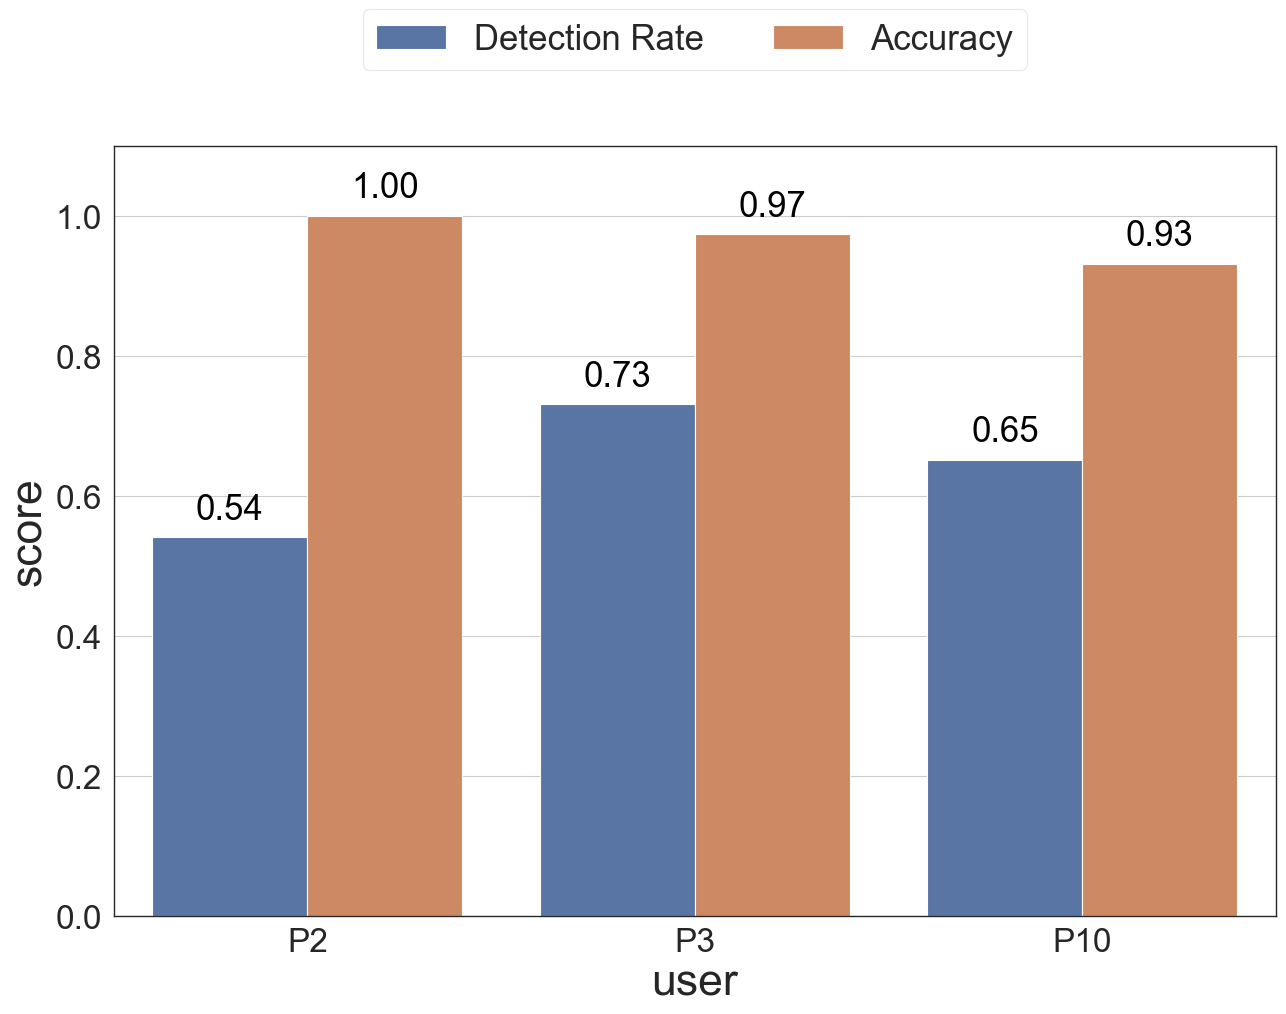

In [476]:
# plot detection rate and accuracy on one bar graph
df_plot = pd.concat([df_detected,df_accuracy]).sort_values(by='user',key=lambda x: x.map({'P2':0,'P3':1,'P10':2}))
fig, axn = plt.subplots(1, 1, figsize=(15,10))
sns.barplot(x='user',y='score',hue='type',data=df_plot)
# add labels
for p in axn.patches:
    axn.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=25, color='black', xytext=(0, 20),
                 textcoords='offset points')
plt.ylim(0,1.1)
plt.legend(loc='upper center', ncol=2,bbox_to_anchor = [0.5, 1.2], fontsize=25)
plt.savefig(f'{plotting_dir}/vax1_phase1_acc_detection_rate.png', dpi=150, bbox_inches='tight')

/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_59539/420207189.py:2: RuntimeWarning: invalid value encountered in divide
  conf_mat_av = conf_mat_av / conf_mat_av.sum(axis=1)[:, np.newaxis]


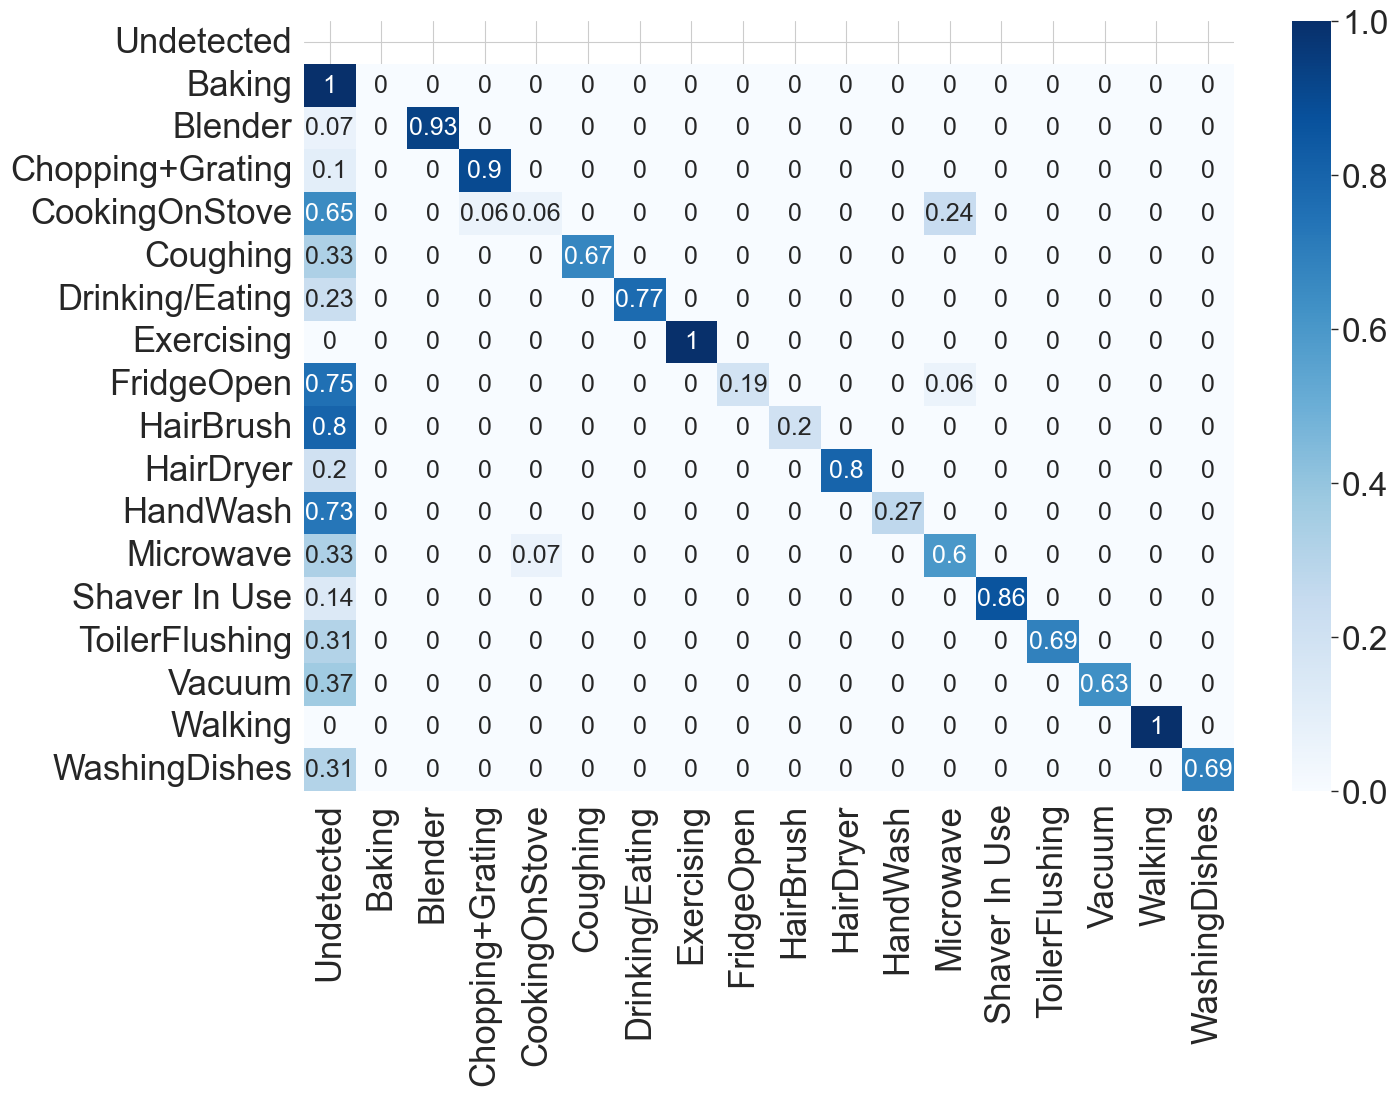

In [373]:
conf_mat_av = np.round(confusion_matrix(df_vax1_phase1_all['groundtruth'], df_vax1_phase1_all['final_prediction'], labels=phase1_activities),1)
conf_mat_av = conf_mat_av / conf_mat_av.sum(axis=1)[:, np.newaxis]
_ = plt.figure(figsize=(15, 10))
sns.heatmap(pd.DataFrame(conf_mat_av[:,:], index=phase1_activities[:], columns=phase1_activities[:]).round(2), annot=True, annot_kws={'size': 18}, cmap='Blues')
_ = plt.xticks(fontsize=25)
_ = plt.yticks(fontsize=25)
plt.savefig(f'{plotting_dir}/vax1_phase1_conf_mat.png', dpi=150, bbox_inches='tight')

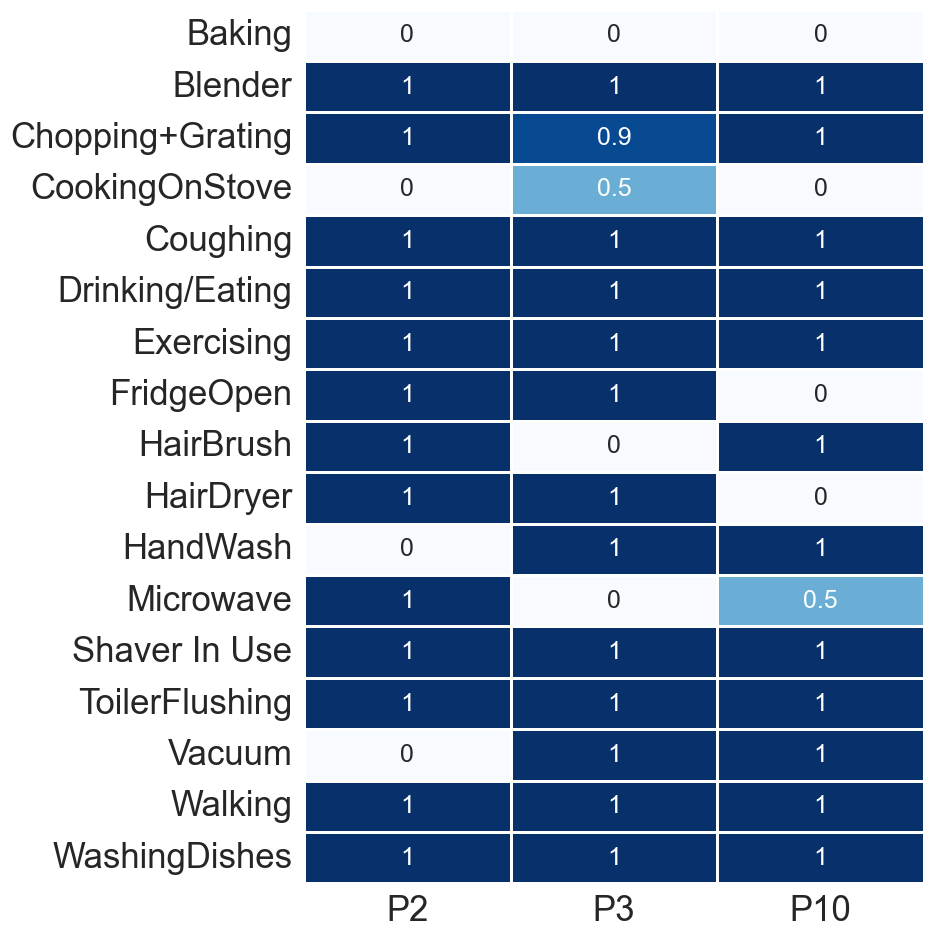

In [374]:
# accuracy, precision, recall at user level
user_precision_all = []
user_f1_all = []
user_apr = []
for user in phase1_users:
    df_result_users = df_vax1_phase1_all[df_vax1_phase1_all.user == user].rename(columns={'final_prediction': 'prediction', 'groundtruth': 'gt'})
    df_result_users = df_result_users[~(df_result_users.prediction == 'Undetected')]
    user_precision_all.append(
        precision_score(df_result_users['gt'], df_result_users['prediction'], average=None, labels=phase1_activities,
                        zero_division=0))
    user_f1_all.append(
        f1_score(df_result_users['gt'], df_result_users['prediction'], average=None, labels=phase1_activities,
                        zero_division=0))
    user_apr.append([
        accuracy_score(df_result_users['gt'], df_result_users['prediction'], ),
        precision_score(df_result_users['gt'], df_result_users['prediction'], average='weighted', labels=phase1_activities,
                        zero_division=0),
        recall_score(df_result_users['gt'], df_result_users['prediction'], average='weighted', labels=phase1_activities,
                     zero_division=0),
    ])
df_f1 = pd.DataFrame(np.array(user_precision_all).T, columns=phase1_users, index=phase1_activities)
_ = plt.figure(figsize=(8, 11.35))
sns.heatmap(df_f1.iloc[1:].round(1), annot=True, annot_kws={'size': 18}, linecolor='w', linewidths=1,cmap='Blues',cbar=False)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig(f'{plotting_dir}/vax1_phase1_precision.png', dpi=150, bbox_inches='tight')
# plt.savefig(f'{plotting_dir}/E1_participant_activity_f1.pdf', dpi=400, bbox_inches='tight')


97.0 96.0 97.0


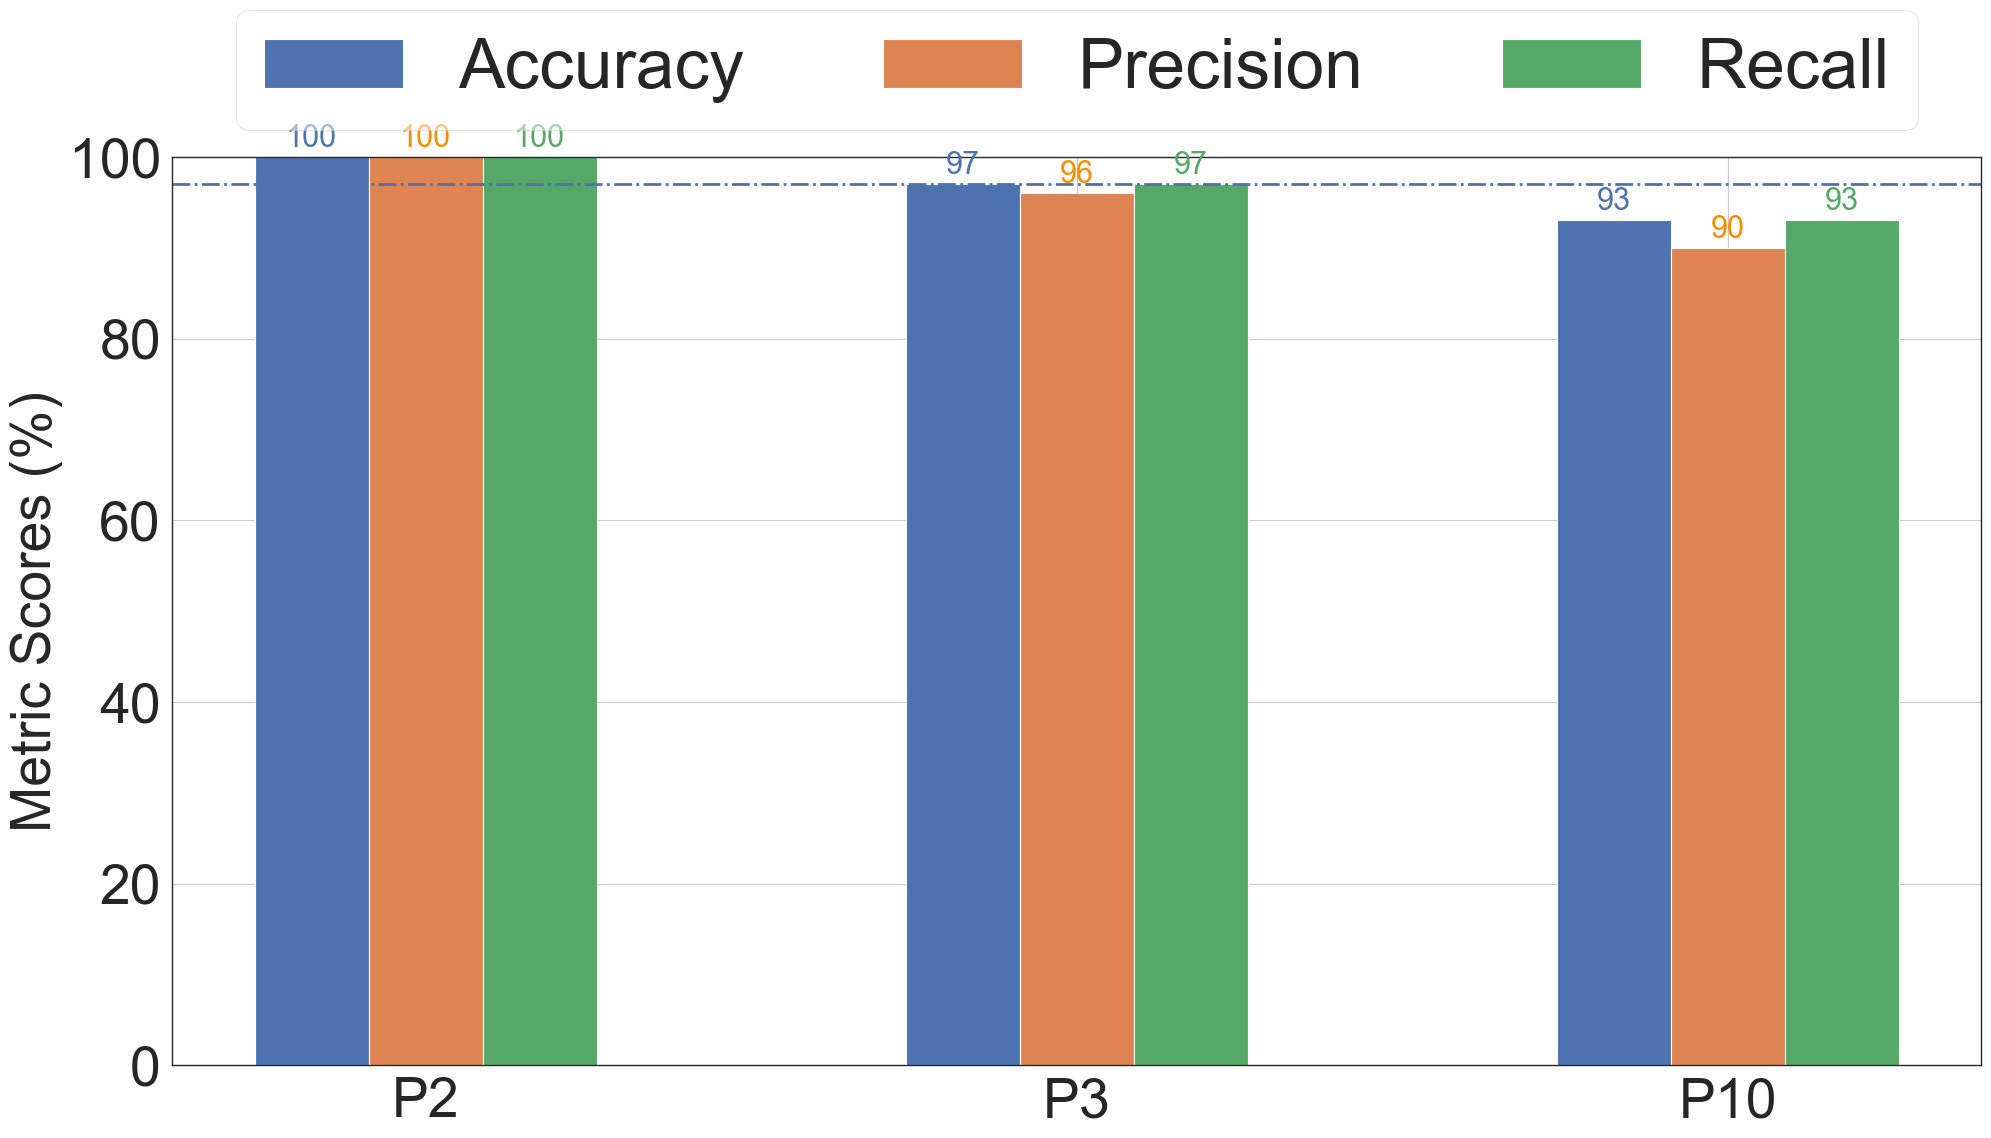

In [375]:
# get accuracy. precision and recall graph
df_apr = pd.DataFrame(user_apr, columns=['Accuracy', 'Precision', 'Recall'], index=phase1_users).round(2) * 100
labels = phase1_users
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
rects1 = ax.bar(x - width / 2, df_apr['Accuracy'], width / 2, label='Accuracy')
rects2 = ax.bar(x, df_apr['Precision'], width / 2, label='Precision')
rects3 = ax.bar(x + width / 2, df_apr['Recall'], width / 2, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Scores (%)', fontsize=40)
# ax.set_title(f'A/P/R Metrics: {k_value} results')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3, fontsize=22,color='b')
ax.bar_label(rects2, padding=3, fontsize=22,color='#ff8c00')
ax.bar_label(rects3, padding=3, fontsize=22,color='g')
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

acc, prec, recall = df_apr.median(axis=0).values
print(acc,prec,recall)
ax.axhline(acc, linestyle='-.', linewidth=2)

fig.tight_layout()
plt.ylim(top=100)
plt.legend(loc='upper center', ncol=3,bbox_to_anchor = [0.5, 1.2], fontsize=50)
plt.savefig(f'{plotting_dir}/vax1_phase1_apr.png', dpi=150, bbox_inches='tight')

# Create Plots for VAX 1.0 Phase 1.5


In [554]:
df_vax1_phase15_all = df_vax1_phase15_results.merge(df_gt_phase15, on=['user','instance_id'], how='left')
df_vax1_phase15_all = df_vax1_phase15_all[~df_vax1_phase15_all.groundtruth.isnull()]
df_vax1_phase15_all.head()

,user,instance_id,final_prediction,final_score,phase,pipeline,groundtruth
0,PHU2,PHU2_0_0,Undetected,0.0,phase15,vax1,UsingCabinet
1,PHU2,PHU2_0_1,Undetected,0.0,phase15,vax1,FridgeOpen
2,PHU2,PHU2_0_2,Undetected,0.0,phase15,vax1,FridgeOpen
3,PHU2,PHU2_0_3,Undetected,0.0,phase15,vax1,FridgeOpen
4,PHU2,PHU2_0_4,Undetected,0.0,phase15,vax1,Microwave


In [555]:

# fraction of undetected instances where groundtruth is not undetected
# df_vax1_phase15_all = df_vax1_phase15_all[df_vax1_phase15_all.groundtruth!='Undetected']
df_vax1_phase15_all[df_vax1_phase15_all.groundtruth!='Undetected'].groupby('user',as_index=False).agg({'final_prediction':lambda x: np.sum(x=='Undetected')/len(x)}).rename(columns={'final_prediction':'fraction_undetected'})

df_detected = df_vax1_phase15_all[df_vax1_phase15_all.groundtruth.isin(phase2_activities)].groupby('user',as_index=False).agg({'final_prediction':lambda x: np.sum(~(x=='Undetected'))/len(x)}).rename(columns={'final_prediction':'score'})
df_detected['type'] = 'Detection Rate'
df_detected


,user,score,type
0,PHU10,0.279310,Detection Rate
1,PHU2,0.099237,Detection Rate
2,PHU3,0.140741,Detection Rate


In [558]:
# accuracy in detected instances
df_vax1_phase15_detected = df_vax1_phase15_all[df_vax1_phase15_all.groundtruth.isin(phase2_activities) & (df_vax1_phase15_all.final_prediction!='Undetected')]
df_vax1_phase15_detected['correct'] = df_vax1_phase15_detected.apply(lambda x: x['final_prediction']==x['groundtruth'], axis=1)
df_vax1_phase15_detected.groupby('user',as_index=False).agg({'correct':'mean'}).rename(columns={'correct':'accuracy'})

df_accuracy = df_vax1_phase15_detected.groupby('user',as_index=False).agg({'correct':'mean'}).rename(columns={'correct':'score'})
df_accuracy['type'] = 'Accuracy'
df_accuracy


,user,score,type
0,PHU10,0.086420,Accuracy
1,PHU2,0.615385,Accuracy
2,PHU3,0.368421,Accuracy


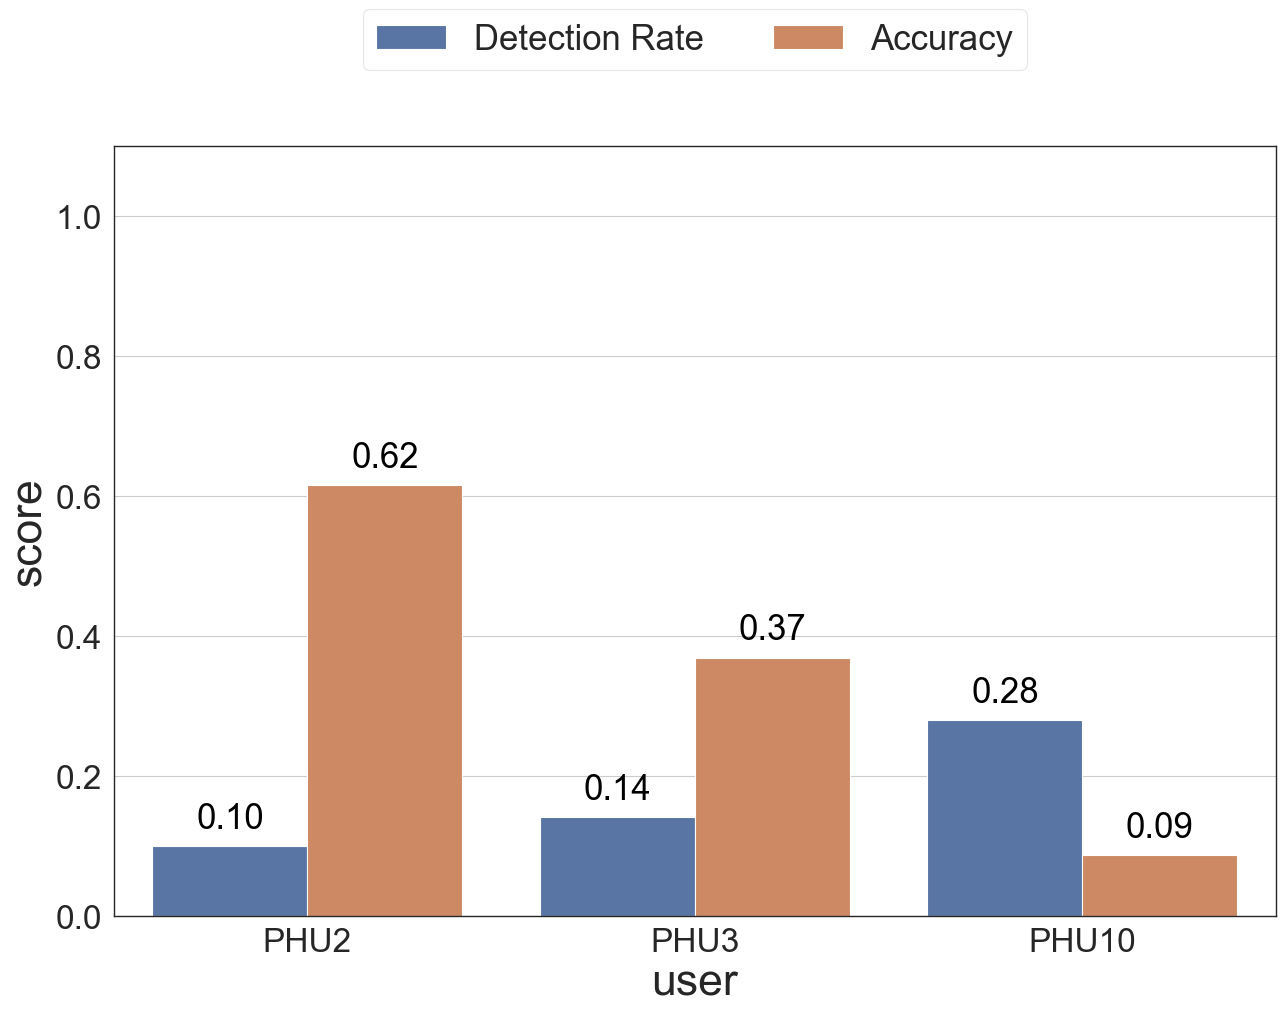

In [559]:
# plot detection rate and accuracy on one bar graph
df_plot = pd.concat([df_detected,df_accuracy]).sort_values(by='user',key=lambda x: x.map({'PHU2':0,'PHU3':1,'PHU10':2}))
fig, axn = plt.subplots(1, 1, figsize=(15,10))
sns.barplot(x='user',y='score',hue='type',data=df_plot)
# add labels
for p in axn.patches:
    axn.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=25, color='black', xytext=(0, 20),
                 textcoords='offset points')
plt.ylim(0,1.1)
plt.legend(loc='upper center', ncol=2,bbox_to_anchor = [0.5, 1.2], fontsize=25)
plt.savefig(f'{plotting_dir}/vax1_phase15_acc_detection_rate.png', dpi=150, bbox_inches='tight')


/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_59539/540427579.py:2: RuntimeWarning: invalid value encountered in divide
  conf_mat_av = conf_mat_av / conf_mat_av.sum(axis=1)[:, np.newaxis]


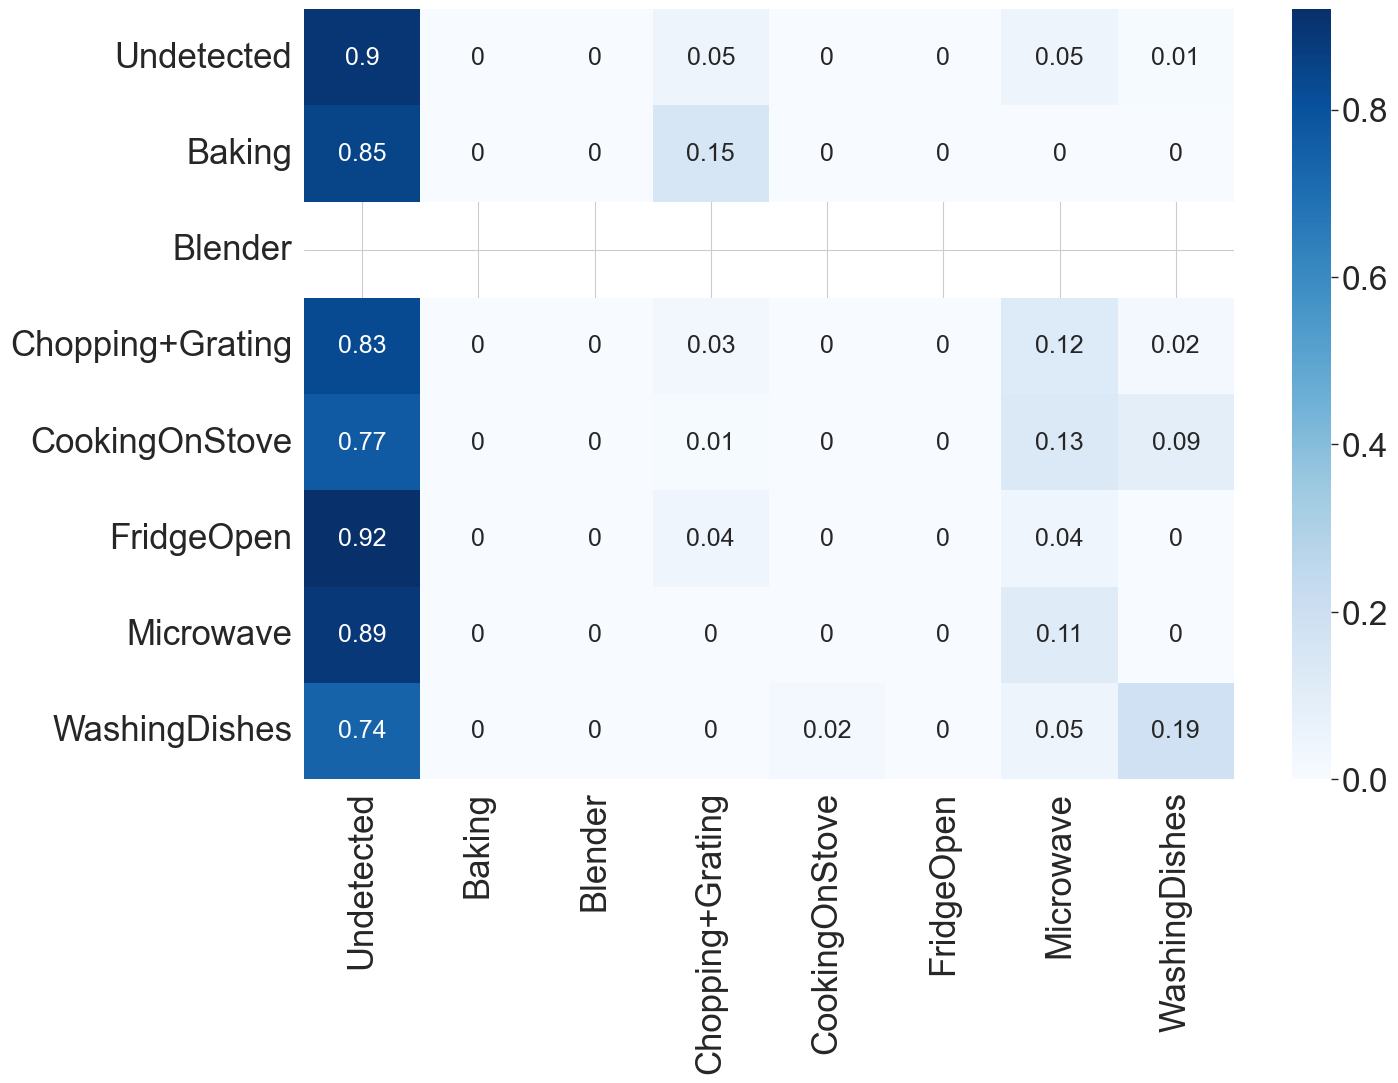

In [380]:
conf_mat_av = np.round(confusion_matrix(df_vax1_phase15_all['groundtruth'], df_vax1_phase15_all['final_prediction'], labels=phase2_activities),1)
conf_mat_av = conf_mat_av / conf_mat_av.sum(axis=1)[:, np.newaxis]
_ = plt.figure(figsize=(15, 10))
sns.heatmap(pd.DataFrame(conf_mat_av[:,:], index=phase2_activities[:], columns=phase2_activities[:]).round(2), annot=True, annot_kws={'size': 18}, cmap='Blues')
_ = plt.xticks(fontsize=25)
_ = plt.yticks(fontsize=25)
plt.savefig(f'{plotting_dir}/vax1_phase15_conf_mat.png', dpi=150, bbox_inches='tight')


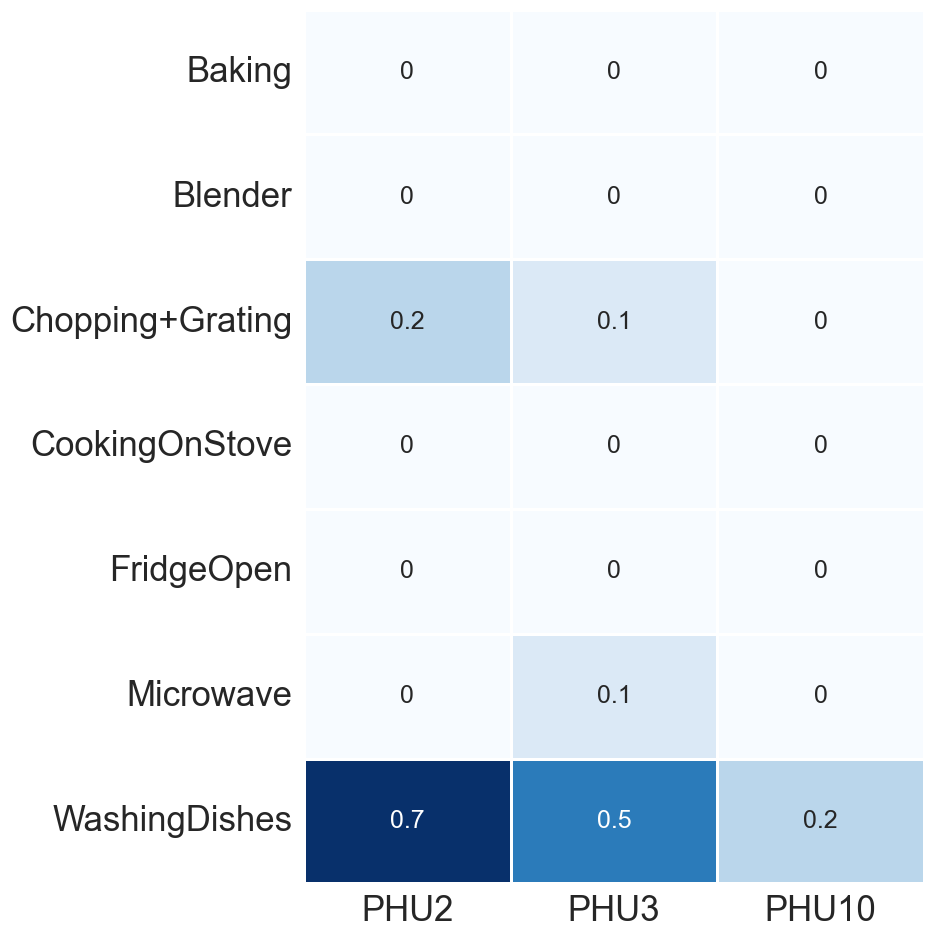

In [381]:

# accuracy, precision, recall at user level
user_precision_all = []
user_f1_all = []
user_apr = []
for user in phase15_users:
    df_result_users = df_vax1_phase15_all[df_vax1_phase15_all.user == user].rename(columns={'final_prediction': 'prediction', 'groundtruth': 'gt'})
    df_result_users = df_result_users[~(df_result_users.prediction == 'Undetected')]
    user_precision_all.append(
        precision_score(df_result_users['gt'], df_result_users['prediction'], average=None, labels=phase2_activities,
                        zero_division=0))
    user_f1_all.append(
        f1_score(df_result_users['gt'], df_result_users['prediction'], average=None, labels=phase2_activities,
                        zero_division=0))
    user_apr.append([
        accuracy_score(df_result_users['gt'], df_result_users['prediction'], ),
        precision_score(df_result_users['gt'], df_result_users['prediction'], average='weighted', labels=phase2_activities,
                        zero_division=0),
        recall_score(df_result_users['gt'], df_result_users['prediction'], average='weighted', labels=phase2_activities,
                     zero_division=0),
    ])
df_f1 = pd.DataFrame(np.array(user_precision_all).T, columns=phase15_users, index=phase2_activities)
_ = plt.figure(figsize=(8, 11.35))
sns.heatmap(df_f1.iloc[1:].round(1), annot=True, annot_kws={'size': 18}, linecolor='w', linewidths=1,cmap='Blues',cbar=False)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig(f'{plotting_dir}/vax1_phase15_precision.png', dpi=150, bbox_inches='tight')
# plt.savefig(f'{plotting_dir}/E1_participant_activity_f1.pdf', dpi=400, bbox_inches='tight')


21.0 8.0 21.0


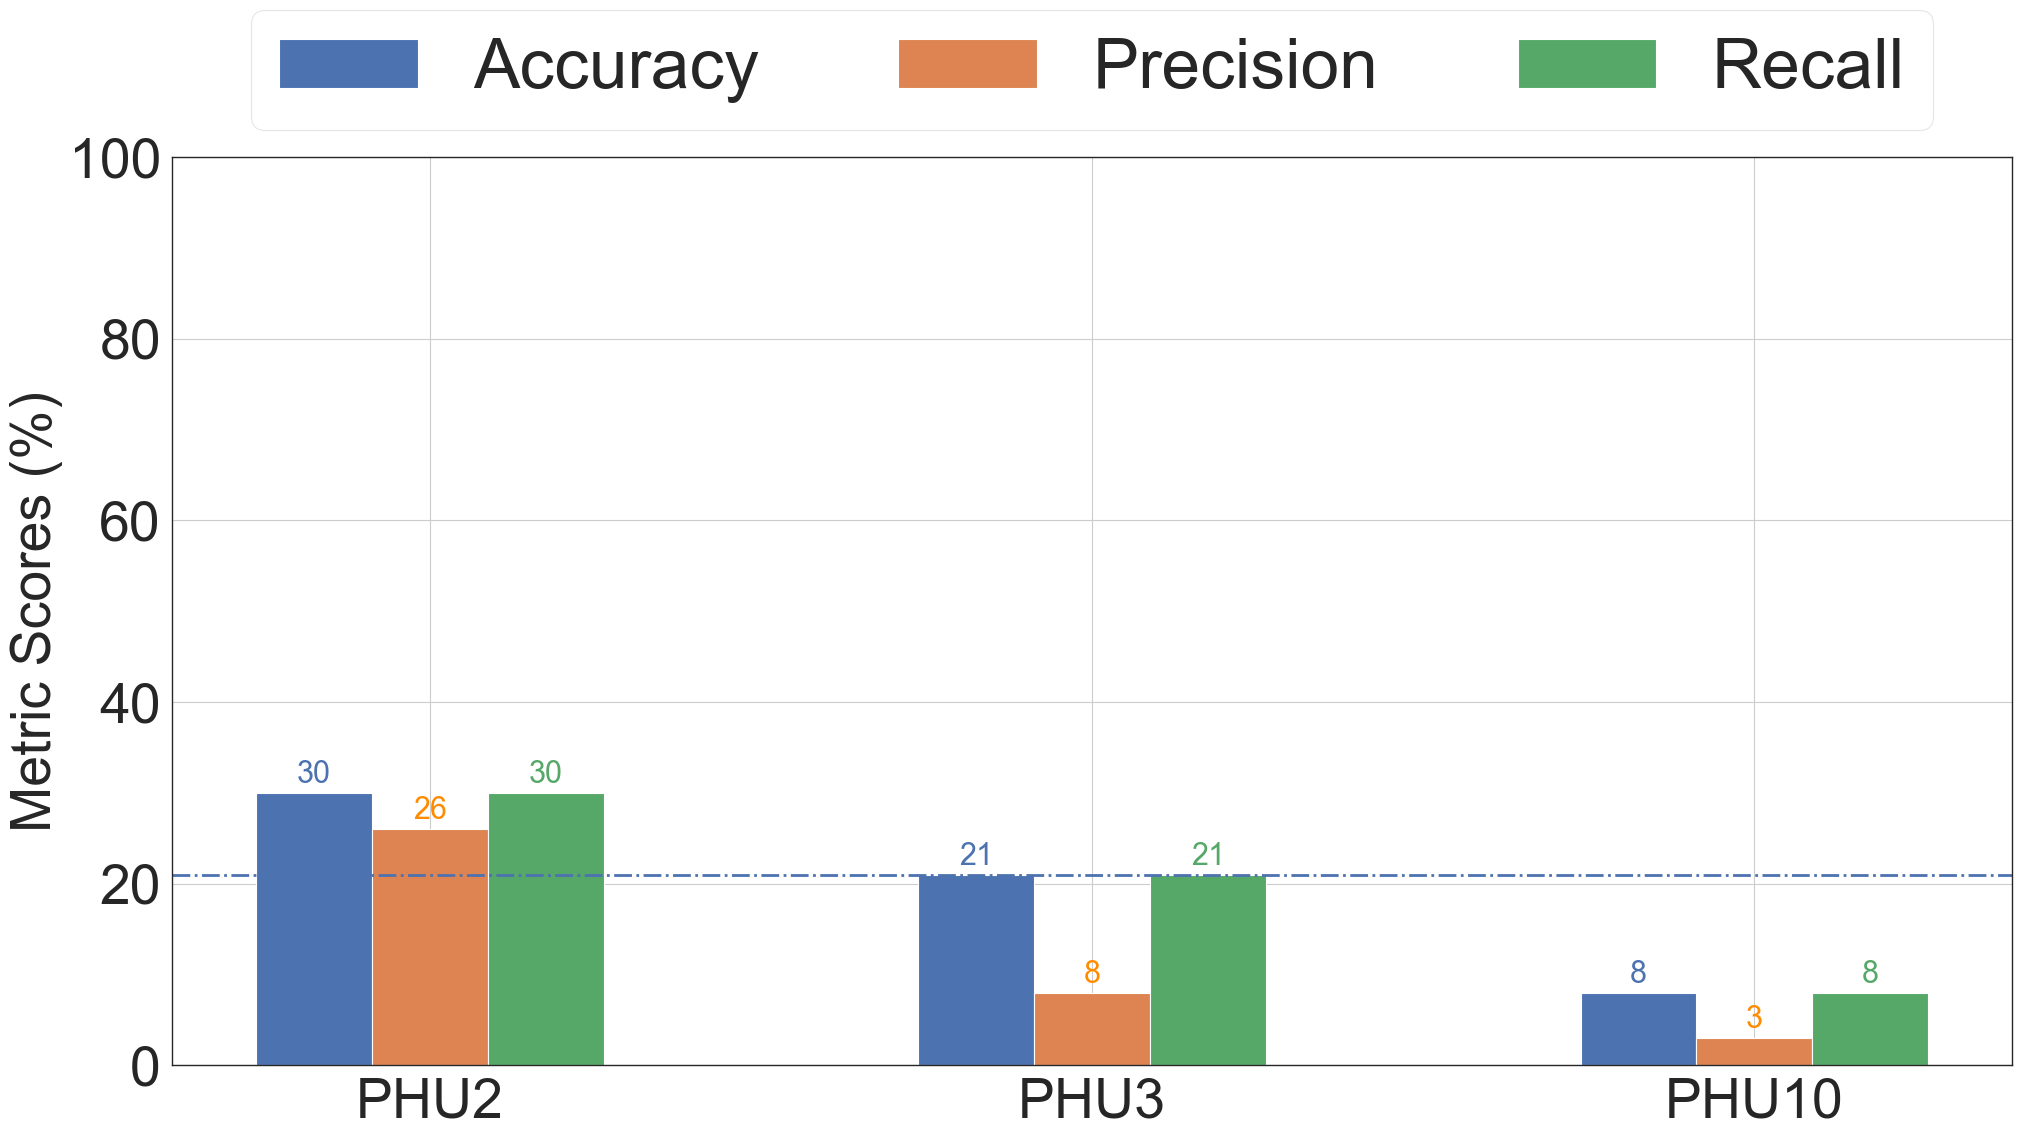

In [382]:
# get accuracy. precision and recall graph
df_apr = pd.DataFrame(user_apr, columns=['Accuracy', 'Precision', 'Recall'], index=phase15_users).round(2) * 100
labels = phase15_users
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
rects1 = ax.bar(x - width / 2, df_apr['Accuracy'], width / 2, label='Accuracy')
rects2 = ax.bar(x, df_apr['Precision'], width / 2, label='Precision')
rects3 = ax.bar(x + width / 2, df_apr['Recall'], width / 2, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Scores (%)', fontsize=40)
# ax.set_title(f'A/P/R Metrics: {k_value} results')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3, fontsize=22,color='b')
ax.bar_label(rects2, padding=3, fontsize=22,color='#ff8c00')
ax.bar_label(rects3, padding=3, fontsize=22,color='g')
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

acc, prec, recall = df_apr.median(axis=0).values
print(acc,prec,recall)
ax.axhline(acc, linestyle='-.', linewidth=2)

fig.tight_layout()
plt.ylim(top=100)
plt.legend(loc='upper center', ncol=3,bbox_to_anchor = [0.5, 1.2], fontsize=50)
plt.savefig(f'{plotting_dir}/vax1_phase15_apr.png', dpi=150, bbox_inches='tight')

# Get results for vax 2.0

In [538]:
undetected_threshold = 0.2

In [539]:
# load phase 1 results for vax 2
def get_vax2_final_prediction(row):
    audio_label, audio_score = 'Undetected', 0.
    video_label, video_score = 'Undetected', 0.
    avg_label, avg_score = 'Undetected', 0
    if row['audio_context_score'] > undetected_threshold:
        audio_label = row['audio_context_pred']
        audio_score = row['audio_context_score']
    if row['video_context_score'] > undetected_threshold:
        video_label = row['video_context_pred']
        video_score = row['video_context_score']
    if row['avg_context_score'] > undetected_threshold:
        avg_label = row['avg_context_pred']
        avg_score = row['avg_context_score']
    if audio_score >= 0. and video_score >= 0.:# chose avg prediction
        final_label = avg_label
        final_score = avg_score
    elif audio_score >= 0. and video_score < 0.:# chose audio prediction
        final_label = audio_label
        final_score = audio_score
    elif audio_score < 0. and video_score >= 0.:# chose video prediction
        final_label = video_label
        final_score = video_score
    return final_label, final_score


In [540]:


vax2_phase1_results = []
for user in phase1_users:
    user_results_file = f"{vax2_phase1_results_dir}/{user}.csv"
    print(user_results_file)
    df_user_results = pd.read_csv(user_results_file)
    df_user_results.info()
    df_user_results = df_user_results[df_user_results.user==user]
    # get final prediction based on undetected threshold
    df_user_results['final_prediction'], df_user_results['final_score'] = zip(*df_user_results.apply(get_vax2_final_prediction, axis=1))
    df_user_results = df_user_results[['user','instance_id','final_prediction', 'final_score']]
    df_user_results['phase'] = 'phase1'
    df_user_results['pipeline'] = 'vax2'
    vax2_phase1_results.append(df_user_results)
df_vax2_phase1_results = pd.concat(vax2_phase1_results)
# combine chopping and grating
df_vax2_phase1_results['final_prediction'] = df_vax2_phase1_results['final_prediction'].apply(lambda x: 'Chopping+Grating' if x in ['Chopping','Grating'] else x)
df_vax2_phase1_results['final_prediction'] = df_vax2_phase1_results['final_prediction'].apply(lambda x: 'Drinking/Eating' if x in ['Drinking','Eating'] else x)
df_vax2_phase1_results.head()
df_vax2_phase1_results.final_prediction.value_counts()

/Users/ppatida2/VAX/vax-public/cache/av_prediction_results/vax2_phase1/P2.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user                 863 non-null    object 
 1   activity             863 non-null    object 
 2   instance_id          863 non-null    object 
 3   avg_context_pred     863 non-null    object 
 4   video_context_pred   863 non-null    object 
 5   audio_context_pred   863 non-null    object 
 6   avg_context_score    863 non-null    float64
 7   video_context_score  863 non-null    float64
 8   audio_context_score  863 non-null    float64
dtypes: float64(3), object(6)
memory usage: 60.8+ KB
/Users/ppatida2/VAX/vax-public/cache/av_prediction_results/vax2_phase1/P3.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 9 columns):
 #   Column               Non-Nul

Undetected          147
Baking               26
Vacuum               23
Drinking/Eating      16
WashingDishes        16
ToilerFlushing       15
Shaver In Use        12
HairDryer             9
Blender               8
HairBrush             7
HandWash              6
Chopping+Grating      5
Walking               4
Microwave             2
CookingOnStove        1
Shower                1
Name: final_prediction, dtype: int64

In [541]:
# load phase 15 results for vax 2
vax2_phase15_results = []
for user in phase15_users:
    user_results_file = f"{vax2_phase15_results_dir}/{user}.csv"
    df_user_results = pd.read_csv(user_results_file)
    df_user_results['user'] =df_user_results['instance_id'].apply(lambda x: x.split('_')[0])
    df_user_results = df_user_results[df_user_results.user==user]
    # get final prediction based on undetected threshold
    df_user_results['final_prediction'], df_user_results['final_score'] = zip(*df_user_results.apply(get_vax2_final_prediction, axis=1))
    df_user_results = df_user_results[['user','instance_id','final_prediction', 'final_score']]
    df_user_results['phase'] = 'phase15'
    df_user_results['pipeline'] = 'vax2'
    vax2_phase15_results.append(df_user_results)
df_vax2_phase15_results = pd.concat(vax2_phase15_results)
# combine chopping and grating
df_vax2_phase15_results['final_prediction'] = df_vax2_phase15_results['final_prediction'].apply(lambda x: 'Chopping+Grating' if x in ['Chopping','Grating'] else x)
df_vax2_phase15_results.head()
df_vax2_phase15_results.final_prediction.value_counts()

Undetected          456
WashingDishes       207
Baking               98
CookingOnStove       72
Chopping+Grating     36
Microwave            34
FridgeOpen           22
Blender               6
Name: final_prediction, dtype: int64

# Create Plots for VAX 2.0 Phase 1

In [525]:
df_vax2_phase1_all = df_vax2_phase1_results.merge(df_gt_phase1, on=['user','instance_id'], how='left')
df_vax2_phase1_all = df_vax2_phase1_all[~df_vax2_phase1_all.groundtruth.isnull()]
df_vax2_phase1_all.head()


,user,instance_id,final_prediction,final_score,phase,pipeline,groundtruth
0,P2,P2_039,Undetected,0.0,phase1,vax2,Baking
1,P2,P2_032,Undetected,0.0,phase1,vax2,Baking
2,P2,P2_034,Undetected,0.0,phase1,vax2,Baking
3,P2,P2_033,Undetected,0.0,phase1,vax2,Baking
4,P2,P2_038,Undetected,0.0,phase1,vax2,Baking


In [526]:
# fraction of undetected instances

df_vax2_phase1_all.groupby('user',as_index=False).agg({'final_prediction':lambda x: np.sum(x=='Undetected')/len(x)}).rename(columns={'final_prediction':'fraction_undetected'})

df_detected = df_vax2_phase1_all.groupby('user',as_index=False).agg({'final_prediction':lambda x: np.sum(~(x=='Undetected'))/len(x)}).rename(columns={'final_prediction':'score'})
df_detected['type'] = 'Detection Rate'
df_detected

,user,score,type
0,P10,0.479167,Detection Rate
1,P2,0.163265,Detection Rate
2,P3,0.386139,Detection Rate


In [527]:
# accuracy in detected instances
df_vax2_phase1_detected = df_vax2_phase1_all[df_vax2_phase1_all.final_prediction!='Undetected']
df_vax2_phase1_detected['correct'] = df_vax2_phase1_detected.apply(lambda x: x['final_prediction']==x['groundtruth'], axis=1)
df_accuracy = df_vax2_phase1_detected.groupby('user',as_index=False).agg({'correct':'mean'}).rename(columns={'correct':'score'})
df_accuracy['type'] = 'Accuracy'
df_accuracy

,user,score,type
0,P10,0.804348,Accuracy
1,P2,0.875000,Accuracy
2,P3,0.820513,Accuracy


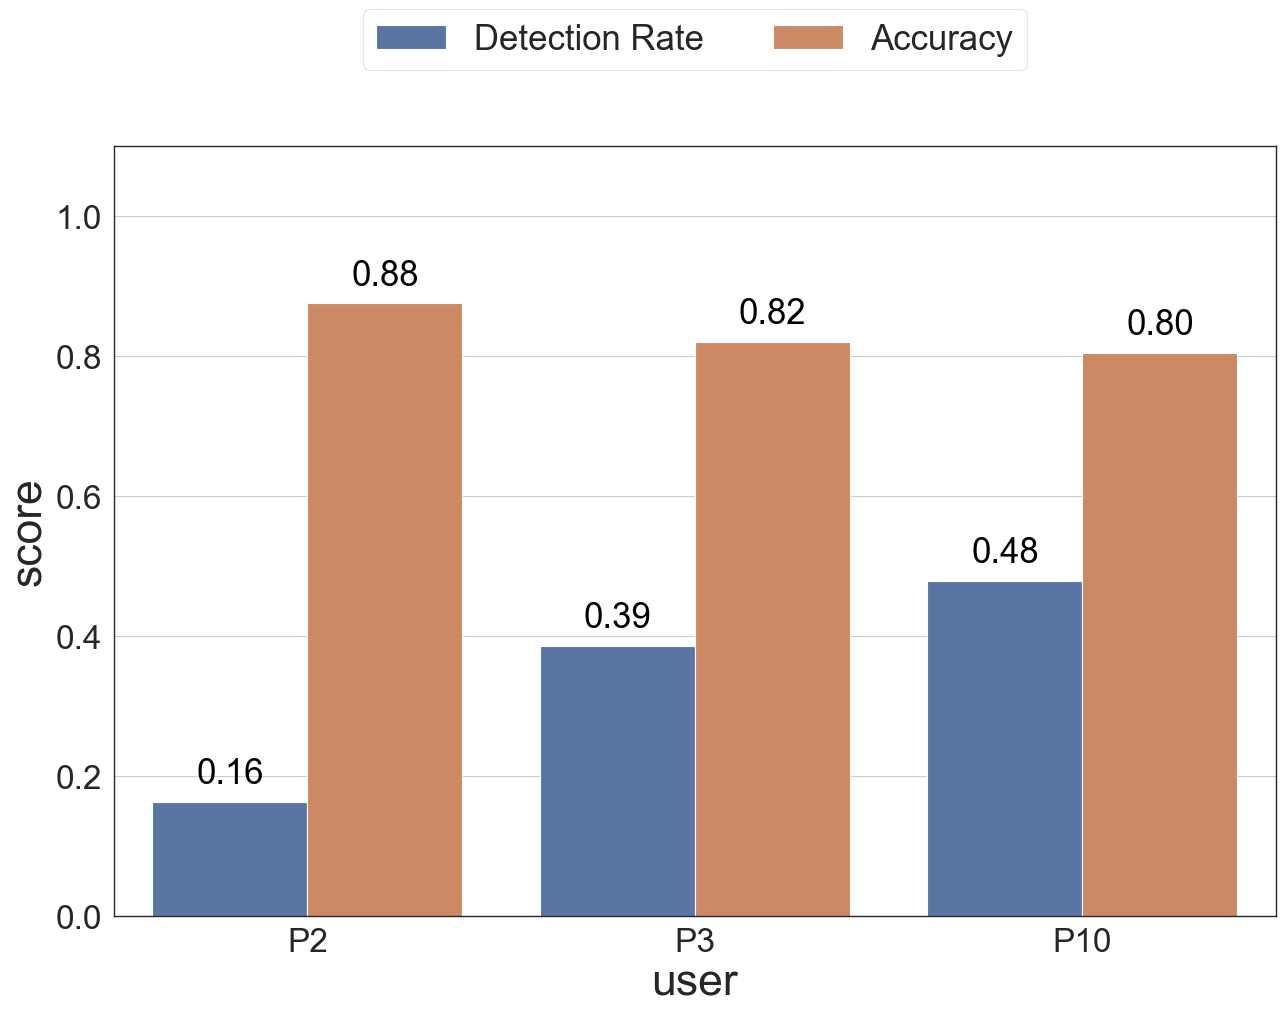

In [528]:
# plot detection rate and accuracy on one bar graph
df_plot = pd.concat([df_detected,df_accuracy]).sort_values(by='user',key=lambda x: x.map({'P2':0,'P3':1,'P10':2}))
fig, axn = plt.subplots(1, 1, figsize=(15,10))
sns.barplot(x='user',y='score',hue='type',data=df_plot)
# add labels
for p in axn.patches:
    axn.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=25, color='black', xytext=(0, 20),
                 textcoords='offset points')
plt.ylim(0,1.1)
plt.legend(loc='upper center', ncol=2,bbox_to_anchor = [0.5, 1.2], fontsize=25)
plt.savefig(f'{plotting_dir}/vax2_phase1_acc_detection_rate_{undetected_threshold}.png', dpi=150, bbox_inches='tight')

/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_59539/1895013009.py:2: RuntimeWarning: invalid value encountered in divide
  conf_mat_av = conf_mat_av / conf_mat_av.sum(axis=1)[:, np.newaxis]


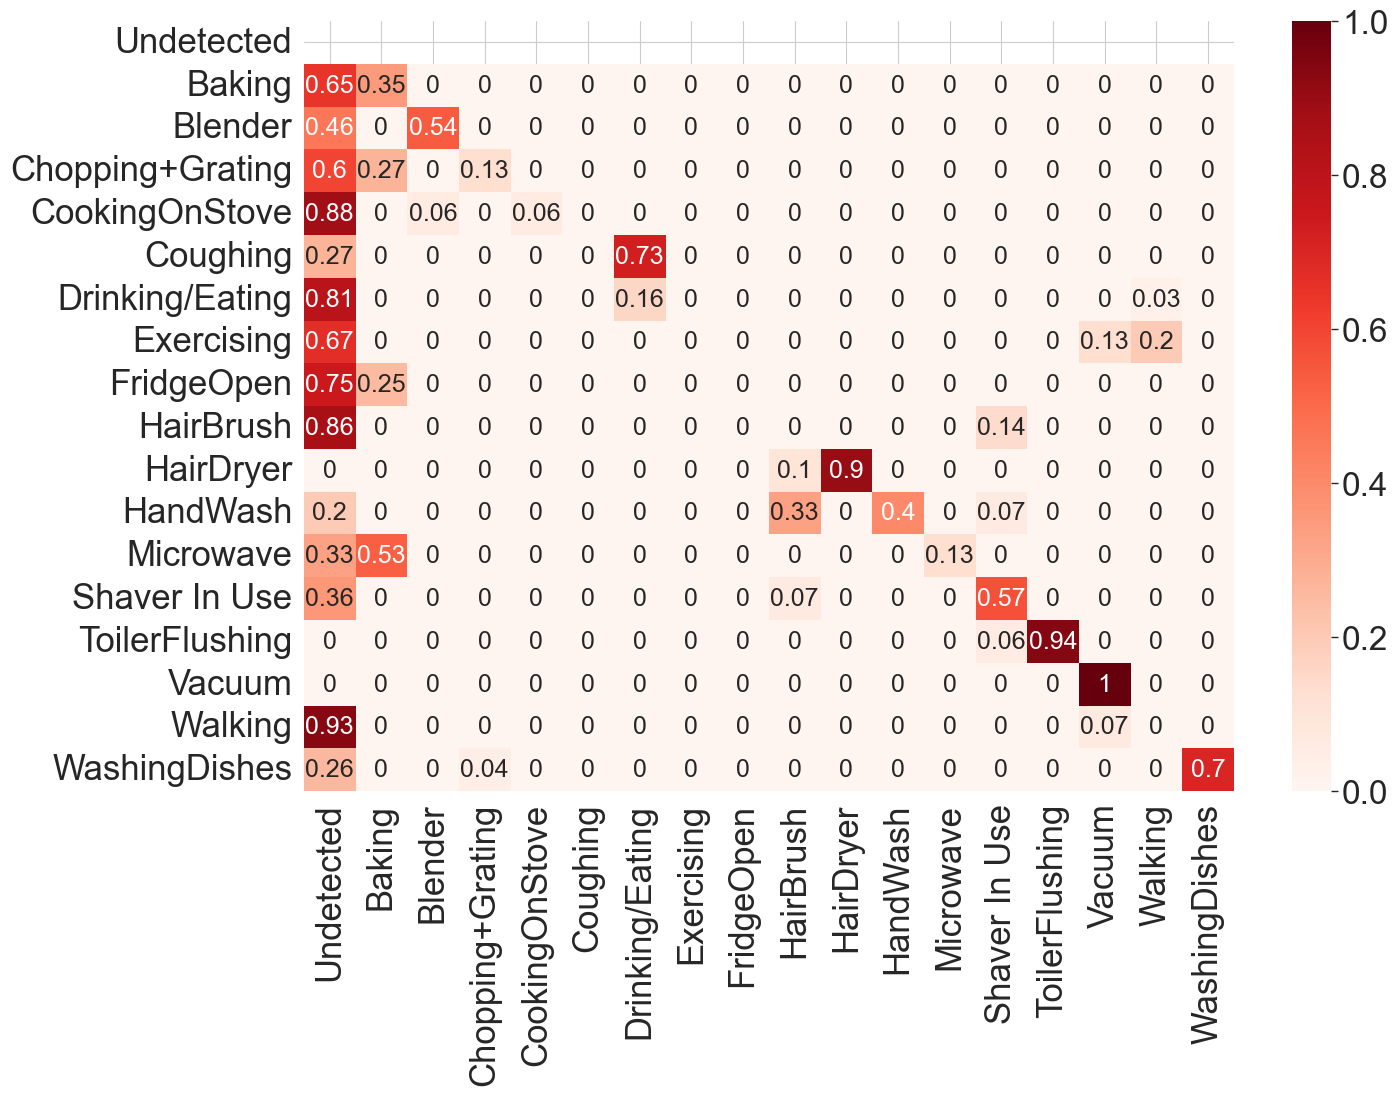

In [491]:
conf_mat_av = np.round(confusion_matrix(df_vax2_phase1_all['groundtruth'], df_vax2_phase1_all['final_prediction'], labels=phase1_activities),1)
conf_mat_av = conf_mat_av / conf_mat_av.sum(axis=1)[:, np.newaxis]
_ = plt.figure(figsize=(15, 10))
sns.heatmap(pd.DataFrame(conf_mat_av[:,:], index=phase1_activities[:], columns=phase1_activities[:]).round(2), annot=True, annot_kws={'size': 18}, cmap='Reds')
_ = plt.xticks(fontsize=25)
_ = plt.yticks(fontsize=25)
plt.savefig(f'{plotting_dir}/vax2_phase1_conf_mat_{undetected_threshold}.png', dpi=150, bbox_inches='tight')


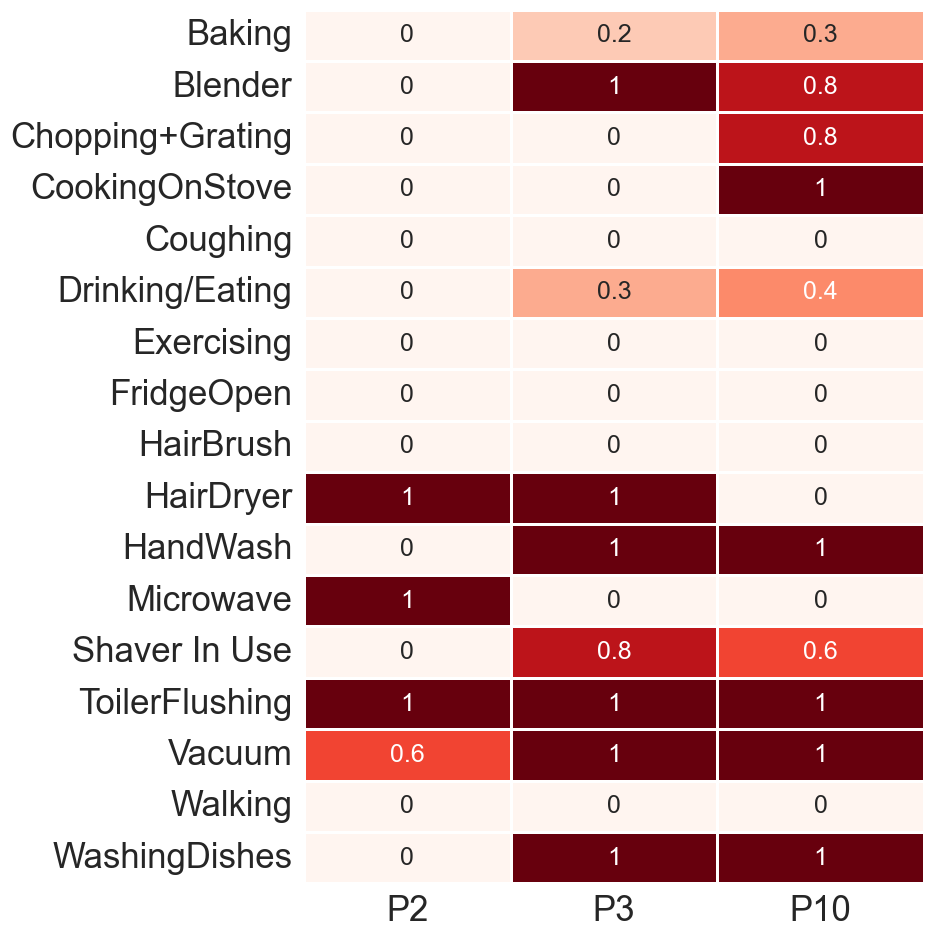

In [492]:

# accuracy, precision, recall at user level
user_precision_all = []
user_f1_all = []
user_apr = []
for user in phase1_users:
    df_result_users = df_vax2_phase1_all[df_vax2_phase1_all.user == user].rename(columns={'final_prediction': 'prediction', 'groundtruth': 'gt'})
    df_result_users = df_result_users[~(df_result_users.prediction == 'Undetected')]
    user_precision_all.append(
        precision_score(df_result_users['gt'], df_result_users['prediction'], average=None, labels=phase1_activities,
                        zero_division=0))
    user_f1_all.append(
        f1_score(df_result_users['gt'], df_result_users['prediction'], average=None, labels=phase1_activities,
                        zero_division=0))
    user_apr.append([
        accuracy_score(df_result_users['gt'], df_result_users['prediction'], ),
        precision_score(df_result_users['gt'], df_result_users['prediction'], average='weighted', labels=phase1_activities,
                        zero_division=0),
        recall_score(df_result_users['gt'], df_result_users['prediction'], average='weighted', labels=phase1_activities,
                     zero_division=0),
    ])
df_f1 = pd.DataFrame(np.array(user_precision_all).T, columns=phase1_users, index=phase1_activities)
_ = plt.figure(figsize=(8, 11.35))
sns.heatmap(df_f1.iloc[1:].round(1), annot=True, annot_kws={'size': 18}, linecolor='w', linewidths=1,cmap='Reds',cbar=False)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig(f'{plotting_dir}/vax2_phase1_precision_{undetected_threshold}.png', dpi=150, bbox_inches='tight')
# plt.savefig(f'{plotting_dir}/E1_participant_activity_f1.pdf', dpi=400, bbox_inches='tight')


In [465]:
# get accuracy. precision and recall graph
# df_apr = pd.DataFrame(user_apr, columns=['Accuracy', 'Precision', 'Recall'], index=phase1_users).round(2) * 100
# labels = phase1_users
# x = np.arange(len(labels))  # the label locations
# width = 0.35  # the width of the bars
# fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# rects1 = ax.bar(x - width / 2, df_apr['Accuracy'], width / 2, label='Accuracy')
# rects2 = ax.bar(x, df_apr['Precision'], width / 2, label='Precision')
# rects3 = ax.bar(x + width / 2, df_apr['Recall'], width / 2, label='Recall')
#
# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Metric Scores (%)', fontsize=40)
# # ax.set_title(f'A/P/R Metrics: {k_value} results')
# ax.set_xticks(x, labels)
# ax.legend()
#
# ax.bar_label(rects1, padding=3, fontsize=22,color='b')
# ax.bar_label(rects2, padding=3, fontsize=22,color='#ff8c00')
# ax.bar_label(rects3, padding=3, fontsize=22,color='g')
# plt.xticks(fontsize=40)
# plt.yticks(fontsize=40)
#
# acc, prec, recall = df_apr.median(axis=0).values
# print(acc,prec,recall)
# ax.axhline(acc, linestyle='-.', linewidth=2)
#
# fig.tight_layout()
# plt.ylim(top=100)
# plt.legend(loc='upper center', ncol=3,bbox_to_anchor = [0.5, 1.2], fontsize=50)
# plt.savefig(f'{plotting_dir}/vax2_phase1_apr.png', dpi=150, bbox_inches='tight')
# plt.savefig(f'{plotting_dir}/E1_apr_participants.pdf', dpi=400, bbox_inches='tight')


# Create Plots for VAX 2.0 Phase 1.5


In [571]:
df_vax2_phase15_all = df_vax2_phase15_results.merge(df_gt_phase15, on=['user','instance_id'], how='left')
df_vax2_phase15_all = df_vax2_phase15_all[~df_vax2_phase15_all.groundtruth.isnull()]
# df_vax2_phase15_all = df_vax2_phase15_all[df_vax2_phase15_all.groundtruth.isin(phase2_activities)]
df_vax2_phase15_all.head()

,user,instance_id,final_prediction,final_score,phase,pipeline,groundtruth
0,PHU2,PHU2_0_0,Undetected,0.000000,phase15,vax2,UsingCabinet
1,PHU2,PHU2_0_1,FridgeOpen,0.247288,phase15,vax2,FridgeOpen
2,PHU2,PHU2_0_2,Undetected,0.000000,phase15,vax2,FridgeOpen
3,PHU2,PHU2_0_3,Undetected,0.000000,phase15,vax2,FridgeOpen
4,PHU2,PHU2_0_4,Baking,0.252578,phase15,vax2,Microwave


In [567]:
# fraction of undetected instances where groundtruth is not undetected


df_vax2_phase15_all[df_vax2_phase15_all.groundtruth!='Undetected'].groupby('user',as_index=False).agg({'final_prediction':lambda x: np.sum(x=='Undetected')/len(x)}).rename(columns={'final_prediction':'fraction_undetected'})

df_detected = df_vax2_phase15_all.groupby('user',as_index=False).agg({'final_prediction':lambda x: np.sum(~(x=='Undetected'))/len(x)}).rename(columns={'final_prediction':'score'})
df_detected['type'] = 'Detection Rate'
df_detected



,user,score,type
0,PHU10,0.600000,Detection Rate
1,PHU2,0.580153,Detection Rate
2,PHU3,0.385185,Detection Rate


In [568]:
# accuracy in detected instances
df_vax2_phase15_detected = df_vax2_phase15_all[df_vax2_phase15_all.final_prediction!='Undetected']
df_vax2_phase15_detected['correct'] = df_vax2_phase15_detected.apply(lambda x: x['final_prediction']==x['groundtruth'], axis=1)
df_vax2_phase15_detected.groupby('user',as_index=False).agg({'correct':'mean'}).rename(columns={'correct':'accuracy'})

df_accuracy = df_vax2_phase15_detected.groupby('user',as_index=False).agg({'correct':'mean'}).rename(columns={'correct':'score'})
df_accuracy['type'] = 'Accuracy'
df_accuracy


,user,score,type
0,PHU10,0.298851,Accuracy
1,PHU2,0.381579,Accuracy
2,PHU3,0.423077,Accuracy


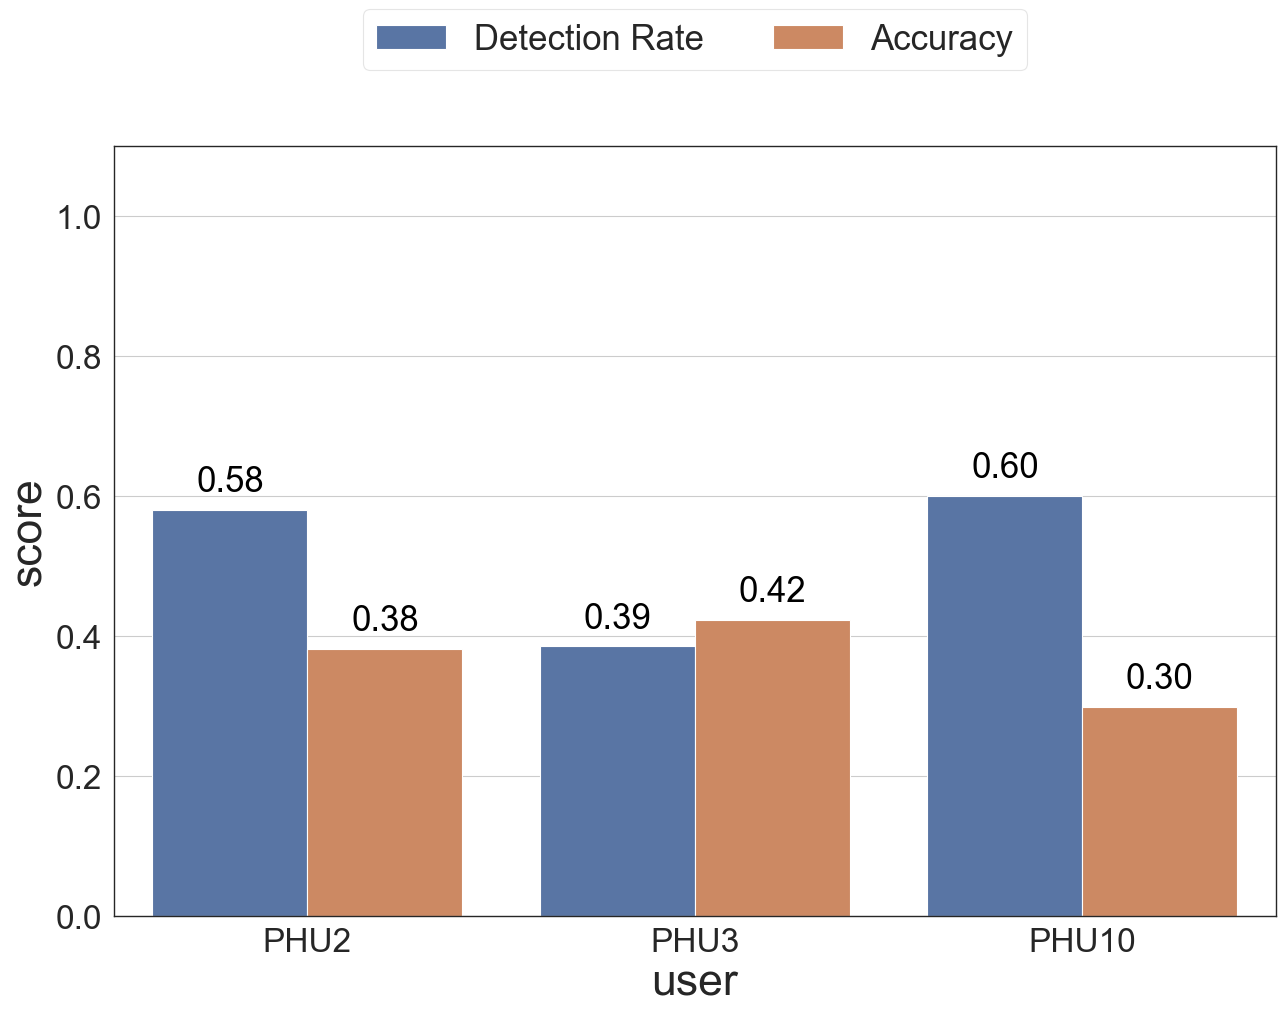

In [569]:
# plot detection rate and accuracy on one bar graph
df_plot = pd.concat([df_detected,df_accuracy]).sort_values(by='user',key=lambda x: x.map({'PHU2':0,'PHU3':1,'PHU10':2}))
fig, axn = plt.subplots(1, 1, figsize=(15,10))
sns.barplot(x='user',y='score',hue='type',data=df_plot)
# add labels
for p in axn.patches:
    axn.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=25, color='black', xytext=(0, 20),
                 textcoords='offset points')
plt.ylim(0,1.1)
plt.legend(loc='upper center', ncol=2,bbox_to_anchor = [0.5, 1.2], fontsize=25)
plt.savefig(f'{plotting_dir}/vax2_phase15_acc_detection_rate_{undetected_threshold}.png', dpi=150, bbox_inches='tight')


In [572]:
gt_labels  = ['Undetected'] + sorted(df_vax2_phase15_all['groundtruth'].unique(), key=lambda x: phase2_activities.index(x) if (x in phase2_activities) else 10)
gt_labels

['Undetected',
 'Baking',
 'Chopping+Grating',
 'CookingOnStove',
 'FridgeOpen',
 'Microwave',
 'WashingDishes',
 'UsingCabinet',
 'OpeningPackets',
 'PreparationForCooking',
 'UsingAirFryer',
 'UsingPhone',
 'Idle',
 'OperatingDishwasher',
 'Cleaning',
 'ServingFood',
 'FillingWater',
 'WashingHands']

/var/folders/tj/q4_hs7215pl0xywz58dv85l00000gp/T/ipykernel_59539/3458440542.py:2: RuntimeWarning: invalid value encountered in divide
  conf_mat_av = conf_mat_av / conf_mat_av.sum(axis=1)[:, np.newaxis]


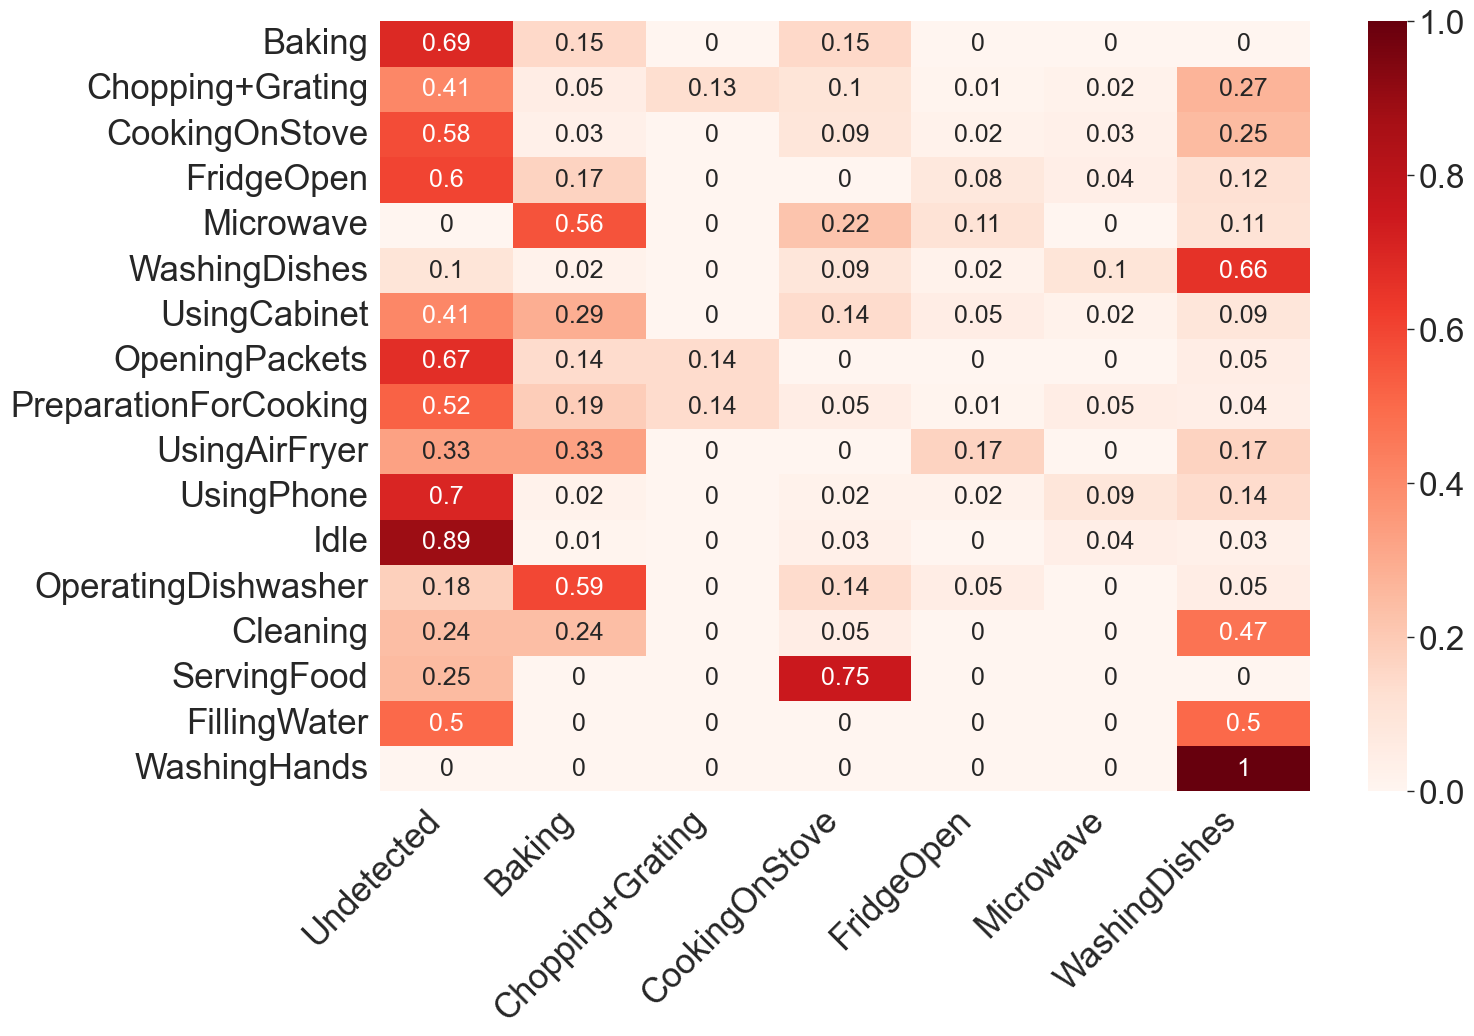

In [574]:

conf_mat_av = np.round(confusion_matrix(df_vax2_phase15_all['groundtruth'], df_vax2_phase15_all['final_prediction'], labels=gt_labels),1)
conf_mat_av = conf_mat_av / conf_mat_av.sum(axis=1)[:, np.newaxis]
_ = plt.figure(figsize=(15, 10))
sns.heatmap(pd.DataFrame(conf_mat_av[1:,:7], index=gt_labels[1:], columns=gt_labels[:7]).round(2), annot=True, annot_kws={'size': 18}, cmap='Reds')
_ = plt.xticks(fontsize=25, rotation=45, ha='right')
_ = plt.yticks(fontsize=25)
plt.savefig(f'{plotting_dir}/vax2_phase15_conf_mat_all_{undetected_threshold}.png', dpi=150, bbox_inches='tight')



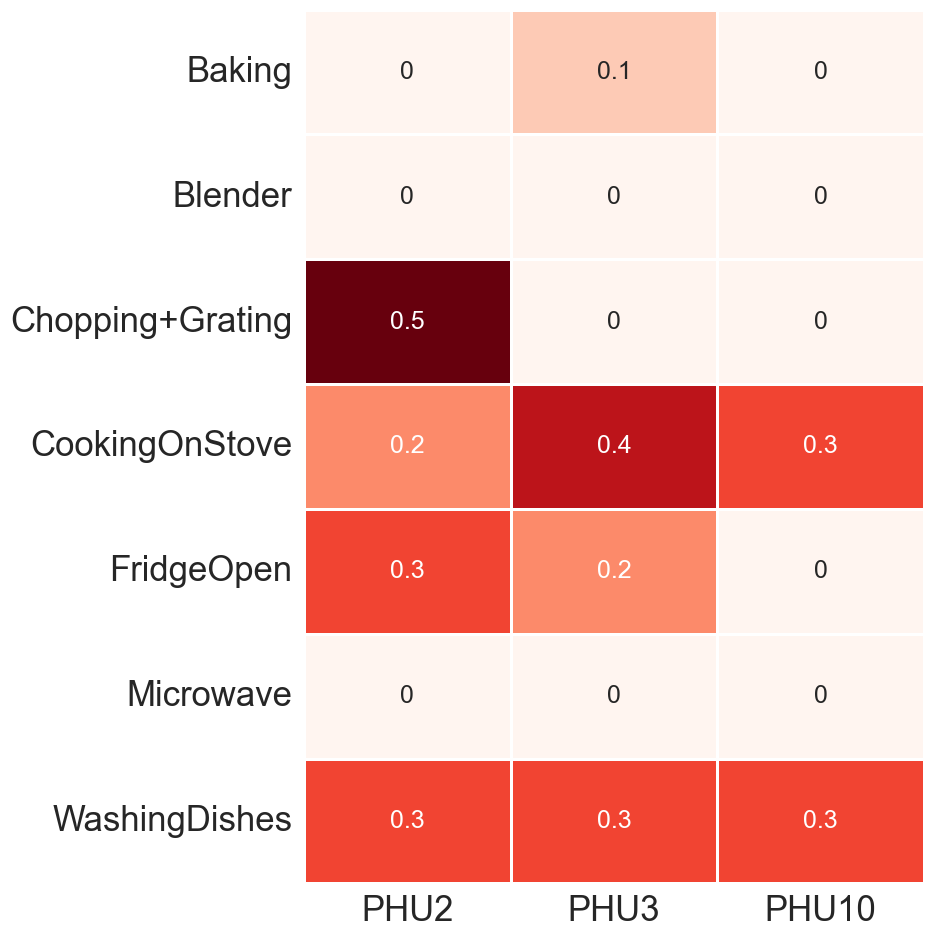

In [498]:
# accuracy, precision, recall at user level
user_precision_all = []
user_f1_all = []
user_apr = []
for user in phase15_users:
    df_result_users = df_vax2_phase15_all[df_vax2_phase15_all.user == user].rename(columns={'final_prediction': 'prediction', 'groundtruth': 'gt'})
    df_result_users = df_result_users[~(df_result_users.prediction == 'Undetected')]
    user_precision_all.append(
        precision_score(df_result_users['gt'], df_result_users['prediction'], average=None, labels=phase2_activities,
                        zero_division=0))
    user_f1_all.append(
        f1_score(df_result_users['gt'], df_result_users['prediction'], average=None, labels=phase2_activities,
                        zero_division=0))
    user_apr.append([
        accuracy_score(df_result_users['gt'], df_result_users['prediction'], ),
        precision_score(df_result_users['gt'], df_result_users['prediction'], average='weighted', labels=phase2_activities,
                        zero_division=0),
        recall_score(df_result_users['gt'], df_result_users['prediction'], average='weighted', labels=phase2_activities,
                     zero_division=0),
    ])
df_f1 = pd.DataFrame(np.array(user_precision_all).T, columns=phase15_users, index=phase2_activities)
_ = plt.figure(figsize=(8, 11.35))
sns.heatmap(df_f1.iloc[1:].round(1), annot=True, annot_kws={'size': 18}, linecolor='w', linewidths=1,cmap='Reds',cbar=False)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig(f'{plotting_dir}/vax2_phase15_precision_{undetected_threshold}.png', dpi=150, bbox_inches='tight')


In [499]:
# get accuracy. precision and recall graph
# df_apr = pd.DataFrame(user_apr, columns=['Accuracy', 'Precision', 'Recall'], index=phase15_users).round(2) * 100
# labels = phase15_users
# x = np.arange(len(labels))  # the label locations
# width = 0.35  # the width of the bars
# fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# rects1 = ax.bar(x - width / 2, df_apr['Accuracy'], width / 2, label='Accuracy')
# rects2 = ax.bar(x, df_apr['Precision'], width / 2, label='Precision')
# rects3 = ax.bar(x + width / 2, df_apr['Recall'], width / 2, label='Recall')
#
# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Metric Scores (%)', fontsize=40)
# # ax.set_title(f'A/P/R Metrics: {k_value} results')
# ax.set_xticks(x, labels)
# ax.legend()
#
# ax.bar_label(rects1, padding=3, fontsize=22,color='b')
# ax.bar_label(rects2, padding=3, fontsize=22,color='#ff8c00')
# ax.bar_label(rects3, padding=3, fontsize=22,color='g')
# plt.xticks(fontsize=40)
# plt.yticks(fontsize=40)
#
# acc, prec, recall = df_apr.median(axis=0).values
# print(acc,prec,recall)
# ax.axhline(acc, linestyle='-.', linewidth=2)
#
# fig.tight_layout()
# plt.ylim(top=100)
# plt.legend(loc='upper center', ncol=3,bbox_to_anchor = [0.5, 1.2], fontsize=50)
# plt.savefig(f'{plotting_dir}/vax2_phase15_apr.png', dpi=150, bbox_inches='tight')


In [575]:
df_gt_phase15[df_gt_phase15.user=='PHU3']

,user,instance_id,groundtruth
267,PHU3,PHU3_0_0,UsingCabinet
268,PHU3,PHU3_0_1,UsingCabinet
269,PHU3,PHU3_0_10,Chopping+Grating
270,PHU3,PHU3_0_11,FridgeOpen
271,PHU3,PHU3_0_12,FridgeOpen
...,...,...,...
545,PHU3,PHU3_9_5,Idle
546,PHU3,PHU3_9_6,Idle
547,PHU3,PHU3_9_7,Idle
548,PHU3,PHU3_9_8,Idle


In [594]:

pose_file = '/Users/ppatida2/VAX/vax-public/cache/phase15_pose/PHU3_0_7.mp4.pb'
pose_results = pickle.load(open(pose_file,'rb'))
type(pose_results[0])

list

In [595]:
pose_results[0][0]['keypoints']

array([[275.13007   , 215.29259   ,   0.9526112 ],
       [275.13007   , 209.84291   ,   0.9463111 ],
       [272.4052    , 209.84291   ,   0.92346966],
       [294.20395   , 198.94356   ,   0.9463771 ],
       [294.20395   , 196.21873   ,   0.5924412 ],
       [316.0027    , 223.46712   ,   0.90549386],
       [305.10333   , 223.46712   ,   0.78535473],
       [324.1772    , 272.51428   ,   0.878958  ],
       [307.82816   , 264.33972   ,   0.72758085],
       [277.85492   , 283.41364   ,   0.8716402 ],
       [283.3046    , 267.06458   ,   0.88982785],
       [316.0027    , 313.38684   ,   0.74295336],
       [305.10333   , 310.66205   ,   0.6897594 ],
       [316.0027    , 378.78302   ,   0.76362216],
       [310.55298   , 373.33337   ,   0.7447972 ],
       [329.6269    , 438.7295    ,   0.72251856],
       [321.45236   , 427.8302    ,   0.6952337 ]], dtype=float32)

In [596]:
keypoint_mapping = {
    0: "Nose",
    1: "Left Eye",
    2: "Right Eye",
    3: "Left Ear",
    4: "Right Ear",
    5: "Left Shoulder",
    6: "Right Shoulder",
    7: "Left Elbow",
    8: "Right Elbow",
    9: "Left Wrist",
    10: "Right Wrist",
    11: "Left Hip",
    12: "Right Hip",
    13: "Left Knee",
    14: "Right Knee",
    15: "Left Ankle",
    16: "Right Ankle"
}

In [601]:
pose_output = []
time = 0
for frame_idx in range(0, len(pose_results), 15):
    frame_pose = pose_results[frame_idx][0]['keypoints']
    frame_pose_dict = {}
    for keypoint_idx in range(len(frame_pose)):
        keypoint = frame_pose[keypoint_idx].astype(float)
        if keypoint[2] > 0.2:
            frame_pose_dict[keypoint_mapping[keypoint_idx]] = tuple(list(keypoint[:2]))
    pose_output.append({'time':time, 'pose':frame_pose_dict})
    time += 1

In [602]:
len(pose_output)

19

In [603]:
json.dump(pose_output, open('/Users/ppatida2/VAX/vax-public/cache/phase15_pose/PHU3_0_7.mp4.json','w'))

In [ ]:
def pose_dict_to_string(pose_output):
    pose_string = ''
    for pose in pose_output:
        pose_string += f'{pose["time"]}:'
        for keypoint in pose['pose']:
            pose_string += f'{keypoint}:{pose["pose"][keypoint][0]},{pose["pose"][keypoint][1]};'
        pose_string += '\n'
    return pose_string

# Running YOLOV8 for videos

In [1]:
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

# Define path to video file
source = '/Users/ppatida2/VAX/vax-public/cache/nas_cache/phase15_study/instance_av_data/PHU3/PHU3_0_7.mp4'

# Run inference on the source
results = model(source, stream=True)  # generator of Results objects

ModuleNotFoundError: No module named 'ultralytics'